In [3]:
# !sudo /opt/conda3/bin/pip install -i http://192.168.101.40/pypi/simple --trusted-host 192.168.101.40 -r utils/pip_list.txt
from main.utils.analysis import *
from main.utils.hyperopt_lgb import *
from main.utils.Inference import *
from main.utils.global_parameters import *
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

class auto_ML(object):
    
    def __init__(self, ):
        try:
            Path(params4eda.get('store_pth')+"/eda results").mkdir(parents=True, exist_ok=True)
        except Exception as e:
            print(f'{e} eda results文件夹生成失败')
            return
        
        print("step 1 获取数据")
        self.data = get_dataset(**{'data_pth': params4eda.get('data_pth'), 'date_colName': params4eda.get('date_colName'),
                                 'y_colName': params4eda.get('y_colName'), 'org_colName': params4eda.get('org_colName'),
                                 'data_encode': params4eda.get('data_encode'), 'key_colNames': params4eda.get('key_colNames'),
                                  'drop_colNames': params4eda.get('drop_colNames')})
        
        self.data = drop_abnormal_ym(**{'data':self.data, 'minYmBadsample': params4eda.get('minYmBadsample'), 
                                 'minYmSample':params4eda.get('minYmSample')})
        self.data_analysis = org_analysis(self.data)
        self.data_analysis.to_csv(params4eda.get('store_pth')+"/eda results/"+"[去除异常月份后]样本分机构信息概览.csv", index=False)
        
        self.oos_data = self.data[self.data.new_org.isin(params4eda.get('oos_orgs'))]
        ## 以渠道channels内的整体作为建模数据，如果包含多个子渠道，整体应为子渠道的并集
        self.data = self.data[self.data.new_org.isin(params4eda.get('channels').get("整体"))]
        print(f'建模样本[去除异常月份]大小为{self.data.shape[0]}, 贷外样本[不做处理]大小为{self.oos_data.shape[0]}')
        
        print(" ")
        print("step 2 去除高缺失率变量")
        if os.path.exists(params4eda.get('store_pth')+"/eda results/"+"变量分机构缺失率.csv") and os.path.exists(params4eda.get('store_pth')+"/eda results/"+"变量分渠道缺失率.csv"):
            self.miss_org = pd.read_csv(params4eda.get('store_pth')+"/eda results/"+"变量分机构缺失率.csv")
            self.miss_channel = pd.read_csv(params4eda.get('store_pth')+"/eda results/"+"变量分渠道缺失率.csv")
        else:
            self.miss_org, self.miss_channel = missing_check(**{'data': self.data, 'channel': params4eda.get('channels')})
            self.miss_org.to_csv(params4eda.get('store_pth')+"/eda results/"+"变量分机构缺失率.csv", index=False)
            self.miss_channel.to_csv(params4eda.get('store_pth')+"/eda results/"+"变量分渠道缺失率.csv", index=False)
        self.data = drop_highmiss_features(**{'data':self.data, 'ratio': params4eda.get('missing_ratio'), 
                                              'cnt': params4eda.get('missing_orgcnt'), 'miss_org': self.miss_org,
                                              'miss_channel': self.miss_channel})
        
        print(" ")
        print("step 3 去除低iv变量")
        if os.path.exists(params4eda.get('store_pth')+"/eda results/"+"变量分机构iv.csv") and os.path.exists(params4eda.get('store_pth')+"/eda results/"+"变量分渠道iv.csv"):
            self.res_iv_org = pd.read_csv(params4eda.get('store_pth')+"/eda results/"+"变量分机构iv.csv")
            self.res_iv_channel = pd.read_csv(params4eda.get('store_pth')+"/eda results/"+"变量分渠道iv.csv")
        else:
            self.res_iv_org, self.res_iv_channel = detect_iv(**{'data':self.data, 'method':params4eda.get('bin_method'), 
                                                                'bins':params4eda.get('bin_cnt'),
                                                                'channel': params4eda.get('channels')})
            self.res_iv_org.to_csv(params4eda.get('store_pth')+"/eda results/"+"变量分机构iv.csv", index=False)
            self.res_iv_channel.to_csv(params4eda.get('store_pth')+"/eda results/"+"变量分渠道iv.csv", index=False)
        self.data = drop_lowiv_features(**{'data':self.data, 'miniv_org':params4eda.get('miniv_org'), 
                               'miniv_channel':params4eda.get('miniv_channel'), 'cnt':params4eda.get('lowiv_orgcnt'),
                               'res_iv_org':self.res_iv_org, 'res_iv_channel': self.res_iv_channel})
        
        print(" ")
        print("step 4 去除高psi变量")
        if os.path.exists(params4eda.get('store_pth')+"/eda results/"+"变量分机构psi.csv") and os.path.exists(params4eda.get('store_pth')+"/eda results/"+"变量分渠道psi.csv"):
            self.res_psi_org = pd.read_csv(params4eda.get('store_pth')+"/eda results/"+"变量分机构psi.csv")
            self.res_psi_channel = pd.read_csv(params4eda.get('store_pth')+"/eda results/"+"变量分渠道psi.csv")
        else:
            self.res_psi_org, self.res_psi_channel = detect_psi(**{'data': self.data, 'channel': params4eda.get('channels')})
            self.res_psi_org.to_csv(params4eda.get('store_pth')+"/eda results/"+"变量分机构psi.csv", index=False)
            self.res_psi_channel.to_csv(params4eda.get('store_pth')+"/eda results/"+"变量分渠道psi.csv", index=False)
        self.data = drop_highpsi_features(**{'data':self.data, 'res_psi_org':self.res_psi_org,
                                             'cnt':params4eda.get('highpsi_orgcntnt'), 'ratio':params4eda.get('max_psi')})
        
        print(" ")
        print("step 5 去除高相似性变量")
        if os.path.exists(params4eda.get('store_pth')+"/eda results/"+"高相似变量对.csv") and os.path.exists(params4eda.get('store_pth')+"/eda results/"+"变量相似性矩阵.csv"):
            self.indices = pd.read_csv(params4eda.get('store_pth')+"/eda results/"+"高相似变量对.csv")
        else:
            self.indices, self.corr = detect_correlation(**{'data':self.data, 'method':params4eda.get('corr_method'),
                                                            'max_corr':params4eda.get('max_corr')})
            self.indices = pd.DataFrame(self.indices)
            self.indices.to_csv(params4eda.get('store_pth')+"/eda results/"+"高相似变量对.csv", index=False)
            self.corr.to_csv(params4eda.get('store_pth')+"/eda results/"+"变量相似性矩阵.csv", index=False)
            self.indices = pd.read_csv(params4eda.get('store_pth')+"/eda results/"+"高相似变量对.csv")
        self.data = drop_highcorrelation_features(**{'data':self.data, 'res_iv_channel':self.res_iv_channel,
                                                     'indices':self.indices, 'channel':'整体'})
        
        print(" ")
        print("step 6 null importance去除高噪音变量")
        self.data = drop_highnoise_features(**{'data': self.data, 'n_estimators':100, 'max_depth': 5})[0]
        try:
            pd.DataFrame(self.data.columns, index=['features']).to_csv(params4eda.get('store_pth')+"/eda results/"+"筛选得到的变量.csv")
        except:
            try:
                pd.DataFrame(self.data.columns).to_csv(params4eda.get('store_pth')+"/eda results/"+"筛选得到的变量.csv")
            except Exception as e:
                print(f"{e}")
        
        print(" ")
        print("step 7超参数寻优类初始化中")
        try:
            Path(params4eda.get('store_pth')+"/hyperopt results").mkdir(parents=True, exist_ok=True)
        except Exception as e:
            print(f'{e} hyperopt results文件夹生成失败')
            return
        
        print("数据集data oos_data执行异常值替换操作, -999 -1111 -1被替换为NaN")
        self.data.replace({-1111:np.nan, -999:np.nan, -1:np.nan}, inplace=True)
        self.oos_data.replace({-1111:np.nan, -999:np.nan, -1:np.nan}, inplace=True)
        params4hyperopt['data'] = self.data
        params4hyperopt['record_train_process'] = False
        self.optlgb = HyperOptLGB(**params4hyperopt)
        self.optlgb1 = HyperOptLGB(**params4hyperopt)
        
        ## 初始化用，大部分参数设为空
        params4inference.update({'param':{'max_depth':2}, 'results':None, 'dataset_statis':None,
                                 'randn':params4hyperopt.get("randn"), 'store_pth': params4eda.get('store_pth'), 'model': None})
        self.inference = Inference(**params4inference)
        print(" ")
        print("EDA & 寻优初始化完毕")
    
    def finetuingParams(self):
        # 参数寻优
        _ = self.optlgb.tpesearch_params()
        
        best_loss = 0
        for idx in np.arange(len(self.optlgb.trails.results)):
            if self.optlgb.trails.results[idx].get('loss') < best_loss:
                best_loss = self.optlgb.trails.results[idx].get('loss')
        for idx in np.arange(len(self.optlgb.trails.results)):
            if self.optlgb.trails.results[idx].get('loss') == best_loss:
                self.param = self.optlgb.trails.results[idx].get('param')
        pd.DataFrame(self.param, index=['0']).to_csv(params4eda.get('store_pth')+"/hyperopt results/"+"最优参数.csv")
        print(f"最优参数为: {self.param}, val mean ks为{best_loss}")
        
        self.param_ = {
            key: hp.choice(key, [value]) for key, value in self.param.items()
        }
        self.optlgb1.params = self.param_
        self.optlgb1.max_iterations = 1
        self.optlgb1.record_train_process = True
        
        ## 重新拟合获得训练日志
        print("重新拟合获得训练日志中")
        _ = self.optlgb1.tpesearch_params()
        
        self.simpler_results = self.optlgb1.trails.results[0].get('simpler_results')
        self.results = self.optlgb1.trails.results[0].get('results')
        self.results['idx'] = self.results.index
        
        self.simpler_results.to_csv(params4eda.get('store_pth')+"/hyperopt results/"+"simpler_results.csv", index=False)
        self.results.to_csv(params4eda.get('store_pth')+"/hyperopt results/"+"results.csv", index=False)
        print("参数寻优完成")
        
    def inference_model(self):
        ## 重新读取results, 保存后的results发生了索引变化
        results = pd.read_csv(params4eda.get('store_pth')+"/hyperopt results/"+"results.csv")
        self.inference.param = self.param
        self.inference.results = results
        self.inference.dataset_statis = self.data_analysis
        self.inference.generate_report(self.data, self.oos_data)

Using TensorFlow backend.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.


In [4]:
auto_ml = auto_ML()

step 1 获取数据
['aft_v4up1_score', 'aft_v4up2_score', 'i_mean_cnt_30daypartner_v4_Loan_all_360day', 'i_cnt_ecipartner_la_Loan_all_365day', 'm_freq_weight_interestLevel_v2_two_clt1v4_Loan_Imbank_90day', 'i_wcInterestLevel_record_v2_Loan_Imbank_180day', 'm_cnt_partner_v4_Loan_all_90day', 'i_cnt_mobile_v4_all_LoanAssistPlat_180day', 'i_incr_set_recent90daypartner_v4_Loan_LoanAssistPlat_365day', 'm_freq_deviceid_v2_all_Imbank_365day', 'i_freq_weight_interestLevel_v2_five_clt1v4_Loan_Imbank_365day', 'm_cf_freq_1dayinterestLevel_two_Loan_all_365day', 'i_cnt_partner_v4_Loan_Bank_365day', 'm_cnt_deviceid_v4_all_all_180day', 'i_max_freq_contdincr30dayrecord_v4_all_LoanAssistPlat_360day', 'i_cnt_partner_v4_Loan_Imbank_180day', 'i_cnt_mobile_v4_all_all_180day', 'i_incr_set_recent90daypartner_v4_all_LoanAssistPlat_365day', 'i_cnt_unslpPartner_Loan_all_30day', 'm_incr_set_recent60dayecipartner_la_Loan_all_360day', 'i_cnt_deviceid_v4_all_all_180day', 'i_incr_set_recent90daypartner_v4_all_all_365day', '

'原始数据大小为(1296945, 426)'

matchingid                          idnumber  \
0  202403280001_100071  22d8a364789d6db3775b9933db375e03   

                             mobile  new_date  new_target  \
0  7e994d7983181bd8418f3050bc850c50  20230820           0   

                 new_org  score_1  score_2  score_3  score_4  ...  \
0  202403280001_长银消金_360  35.4771  37.8263  46.8573  48.9574  ...   

   m_ratio_freq_record_v2_Loan_P2p_365day  \
0                                     0.0   

   m_ratio_freq_record_v3_Loan_Imbank_180day  \
0                                        0.7   

   m_ratio_interestLevel_six_Loan_all_365day  \
0                                     0.0909   

   m_ratio_interestLevel_three_Loan_all_180day  \
0                                        0.625   

   m_ratio_interestLevel_three_Loan_all_365day  \
0                                       0.6364   

   m_std_cnt_30daypartner_v3_all_all_360day  \
0                                    1.3819   

   m_wcInterestLevel_partner_Loan_all_90day  \
0                                       3.5   

   m_wcInterestLevel_partner_v2_Loan_Imbank_365day  \
0                                             46.5   

   m_wcInterestLevel_record_v2_Loan_Imbank_365day  new_date_ym  
0                                            60.5       202308  

[1 rows x 426 columns]

'输入data样本数为1296945, 限制每个机构每月坏样本数>=5, 样本数>=0'

'删去异常月份后数据大小为1282679'

建模样本[去除异常月份]大小为1093107, 贷外样本[不做处理]大小为147338
 
step 2 去除高缺失率变量


'输入data列数为426'

'删去高缺失变量后data列数为314, 删去112列, 删除标准：1.变量在多个机构下不满足单机构缺失率条件, 2.变量在渠道或总体下不满足缺失率条件'

 
step 3 去除低iv变量


'没有符合删去条件的变量'

 
step 4 去除高psi变量


'没有变量符合删去要求'

 
step 5 去除高相似性变量


'根据整体下iv值删去变量, 遍历高相似变量对直到变量对全为空, 对于iv>=0.01的变量对进行了特殊处理从而尽可能保留高价值变量'

'共删去108个变量'

 
step 6 null importance去除高噪音变量
(AUC) train:0.705, test:0.703, train_permuted:0.547, test_permuted:0.501
(AUC) train:0.706, test:0.7, train_permuted:0.549, test_permuted:0.5


'共有2个变量存在过高噪音, 翻转y后建模gain值差异小于50'

 
step 7超参数寻优类初始化中
数据集data oos_data执行异常值替换操作, -999 -1111 -1被替换为NaN
 
EDA & 寻优初始化完毕


In [5]:
auto_ml.finetuingParams()

'开始执行时间：2025-07-27 19:37:32'

  0%|          | 0/5 [00:00<?, ?it/s, best loss: ?]

'当前组参数训练耗时：10.13分'

 20%|██        | 1/5 [10:07<40:30, 607.71s/it, best loss: -0.3093897748188846]

'当前组参数训练耗时：9.3分'

 40%|████      | 2/5 [19:25<29:38, 592.79s/it, best loss: -0.3093897748188846]

'当前组参数训练耗时：13.46分'

 60%|██████    | 3/5 [32:53<21:54, 657.27s/it, best loss: -0.3171961322221461]

'当前组参数训练耗时：17.46分'

 80%|████████  | 4/5 [50:20<12:54, 774.29s/it, best loss: -0.3171961322221461]

'当前组参数训练耗时：10.01分'

100%|██████████| 5/5 [1:00:21<00:00, 722.11s/it, best loss: -0.3171961322221461]
最优参数为: {'balanced_badrate': 6.0, 'boosting_type': 'gbdt', 'broadcast_with_tar': False, 'colsample_bytree': 0.75, 'learning_rate': 0.07, 'max_bin': 100, 'max_depth': 5, 'metric': 'auc', 'min_child_samples': 6000, 'num_iterations': 400, 'num_threads': 1, 'objective': 'binary', 'reg_alpha': 60.0, 'reg_lambda': 65.0}, val mean ks为-0.3171961322221461
重新拟合获得训练日志中


'开始执行时间：2025-07-27 20:37:53'

  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

'当前组参数训练耗时：50.64分'

100%|██████████| 1/1 [50:38<00:00, 3038.22s/it, best loss: -0.3171961322221461]
参数寻优完成


step 1 计算cv oos结果
step 2 使用data拟合模型
data与oos_data的模型得分psi是0.0522
step 3 计算模型得分&子分等频10分箱
step 4 分机构计算模型得分&子分等频10分箱
step 5 生成评分趋势图
step 6 生成训练过程图
step 7 生成模型报告中
已完成模型报告


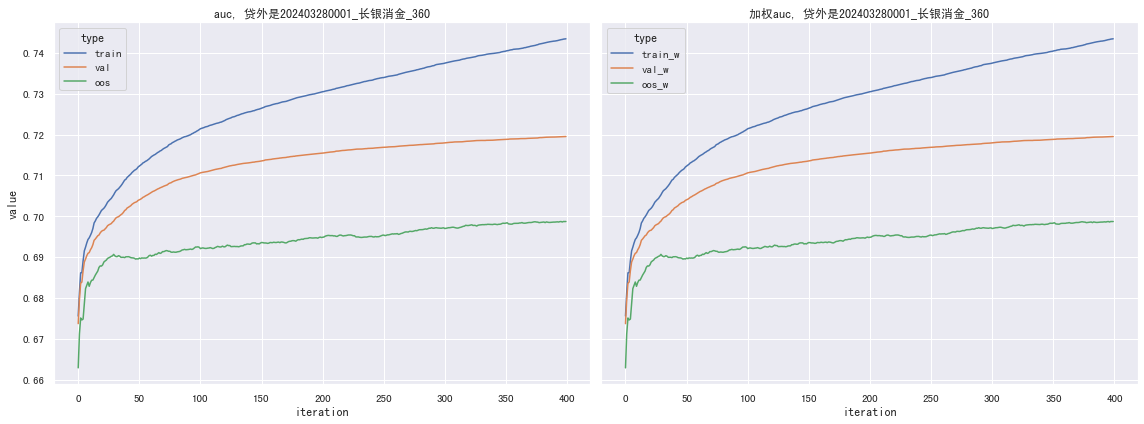

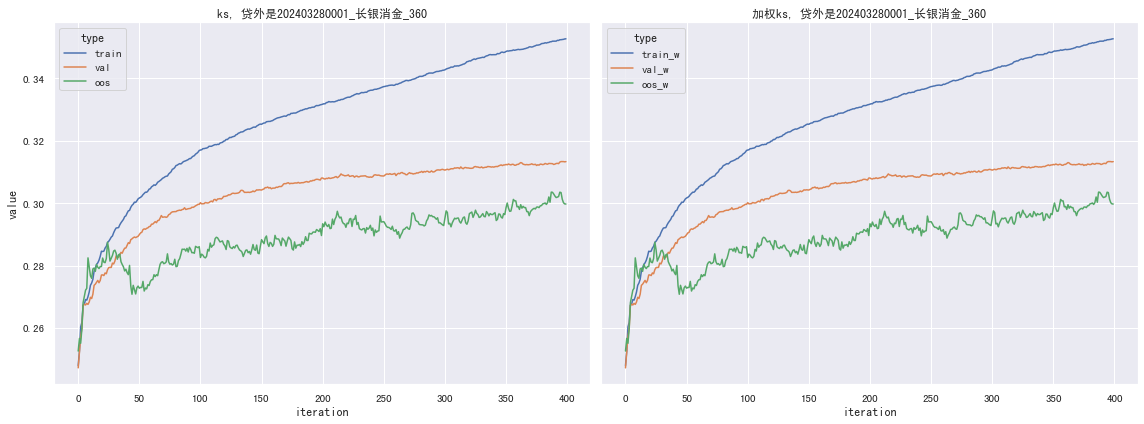

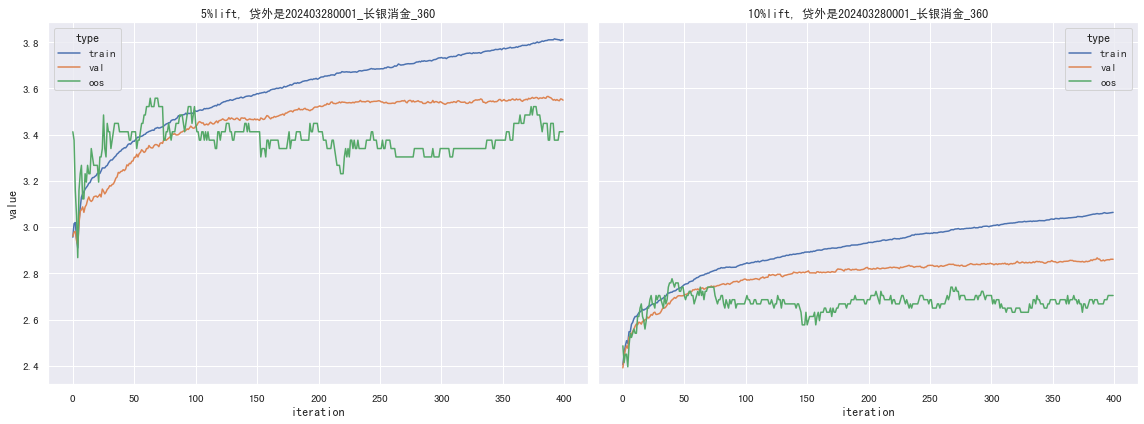

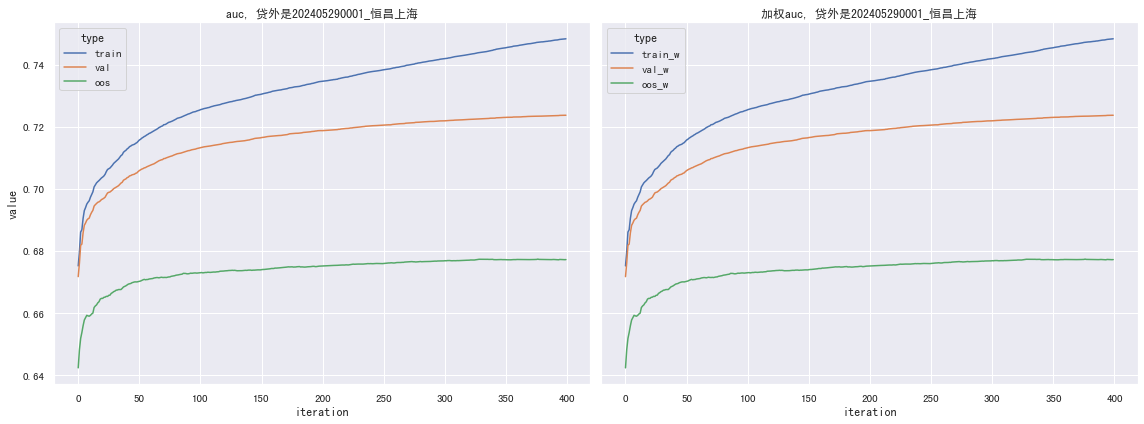

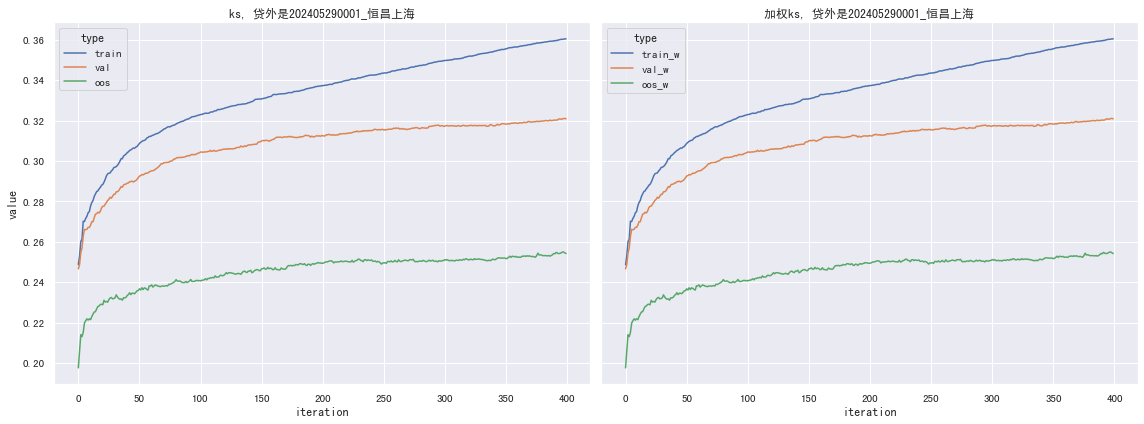

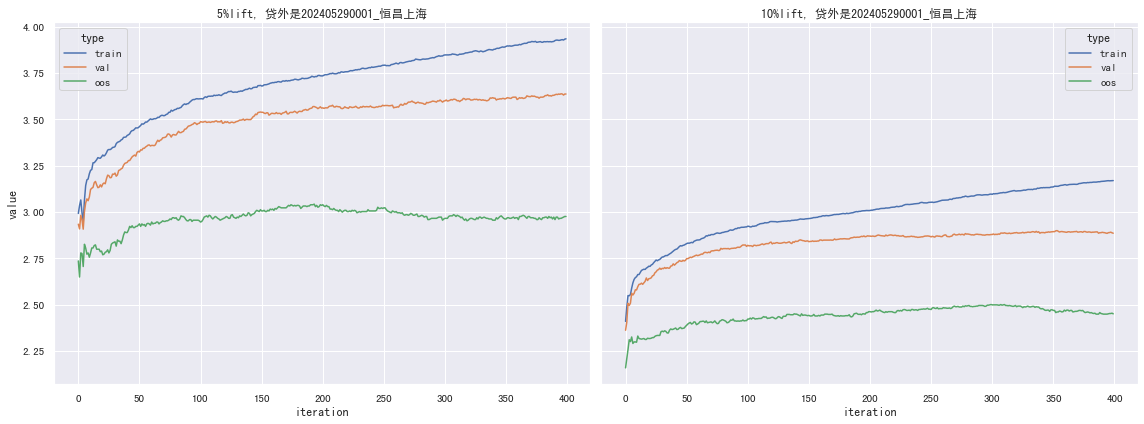

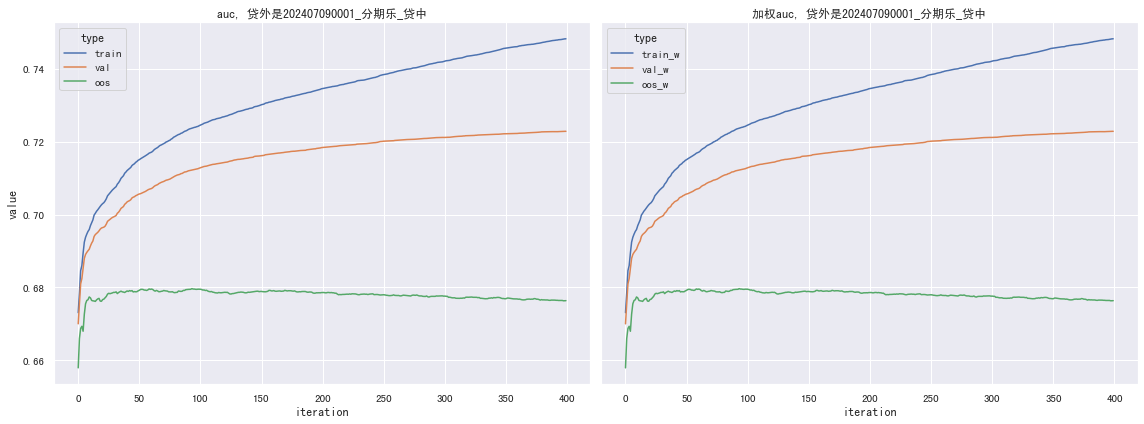

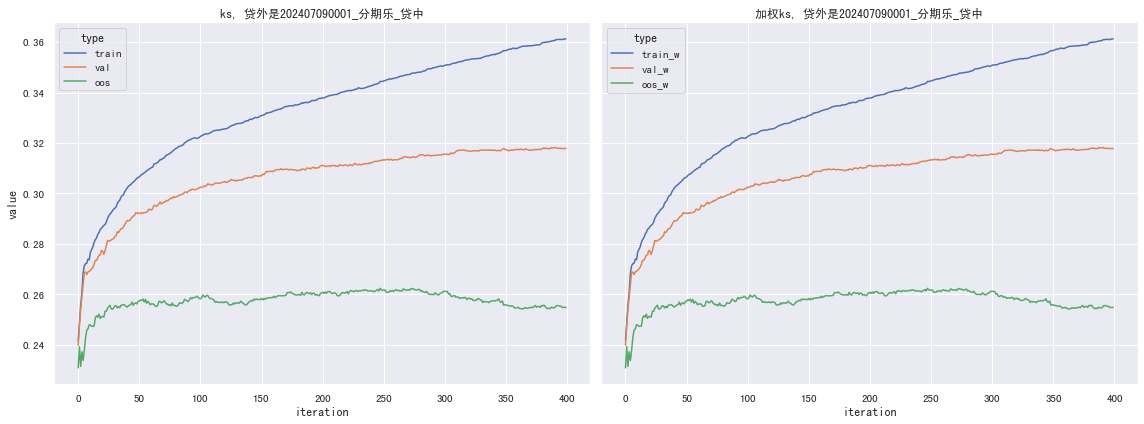

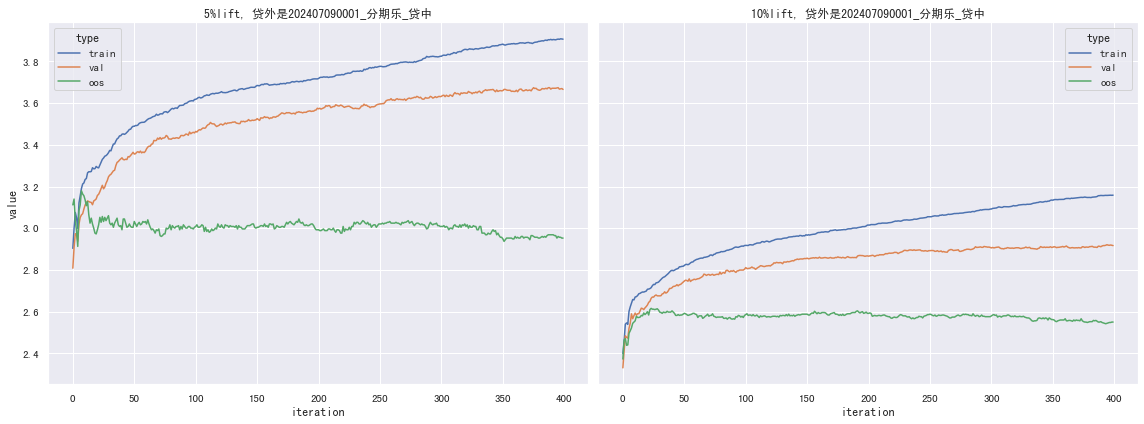

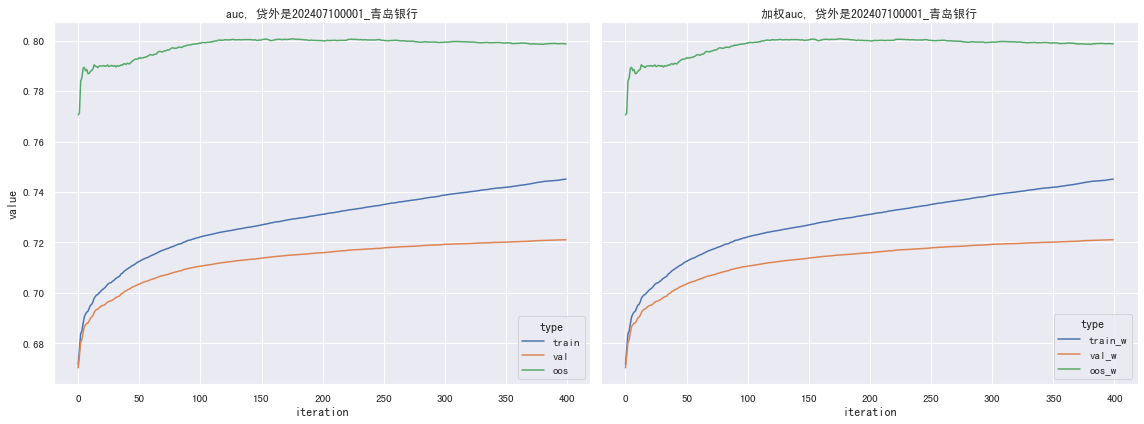

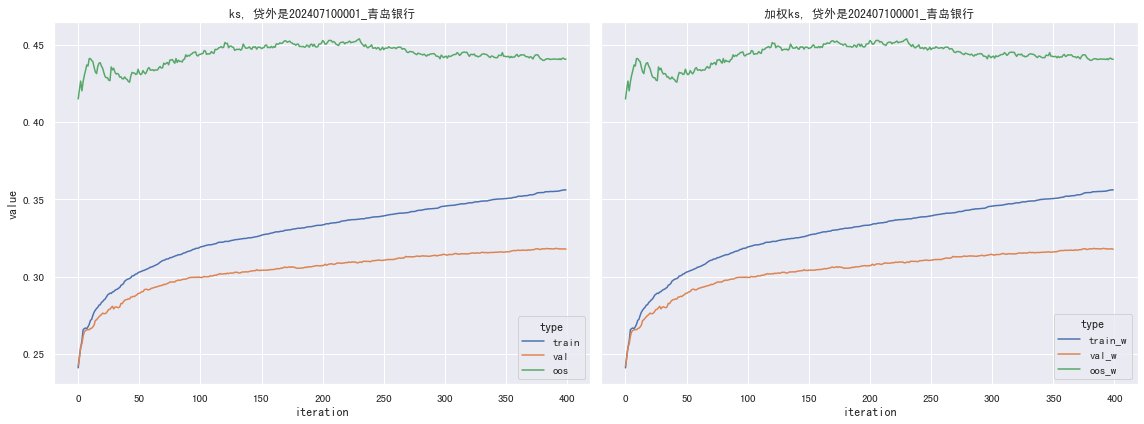

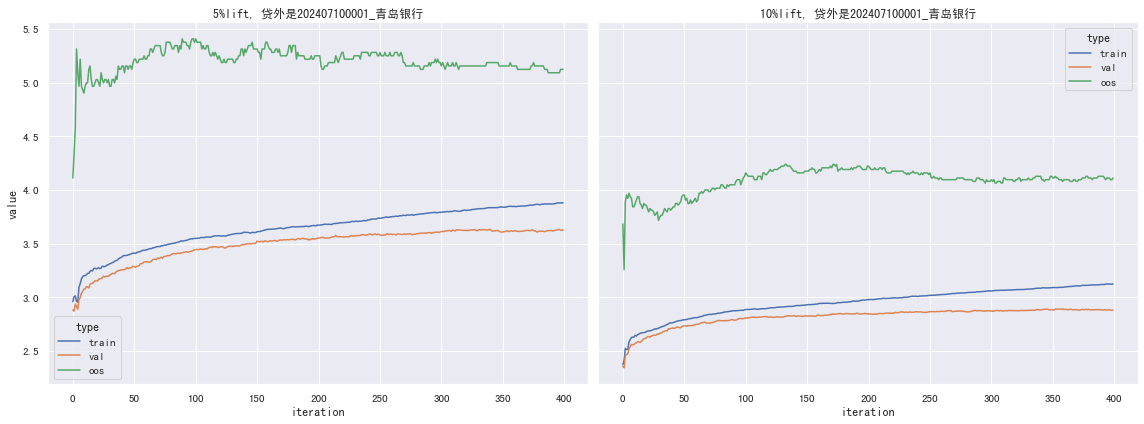

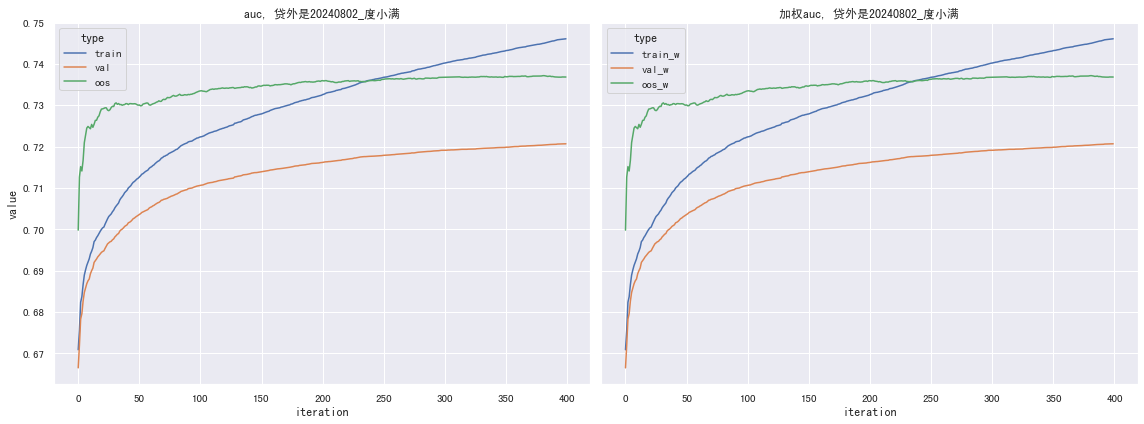

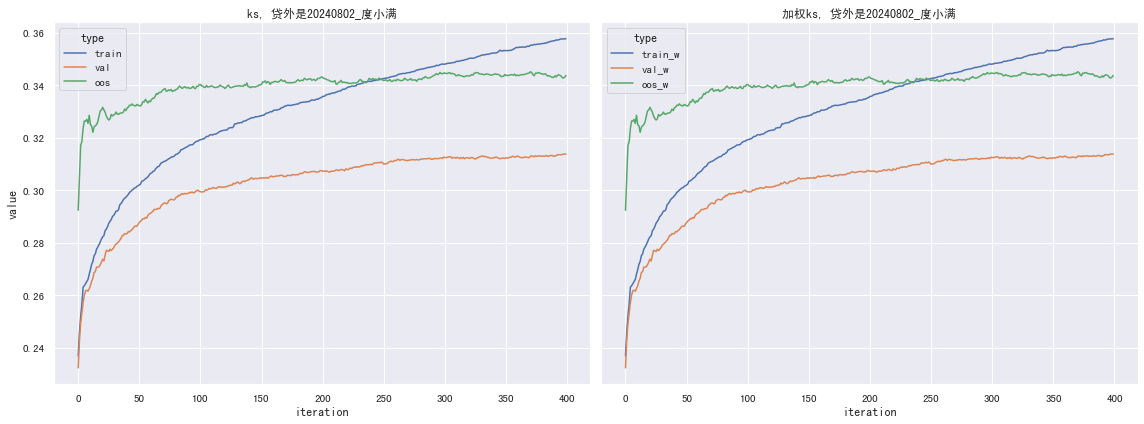

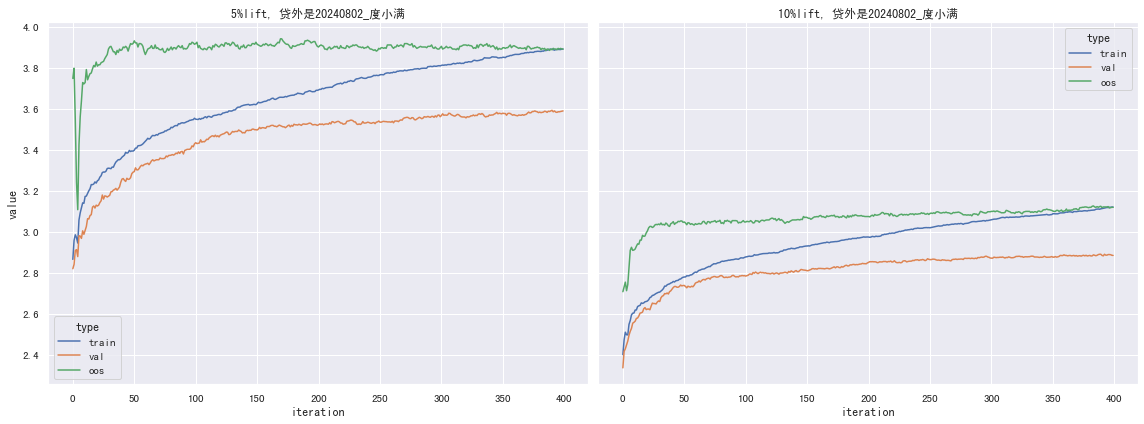

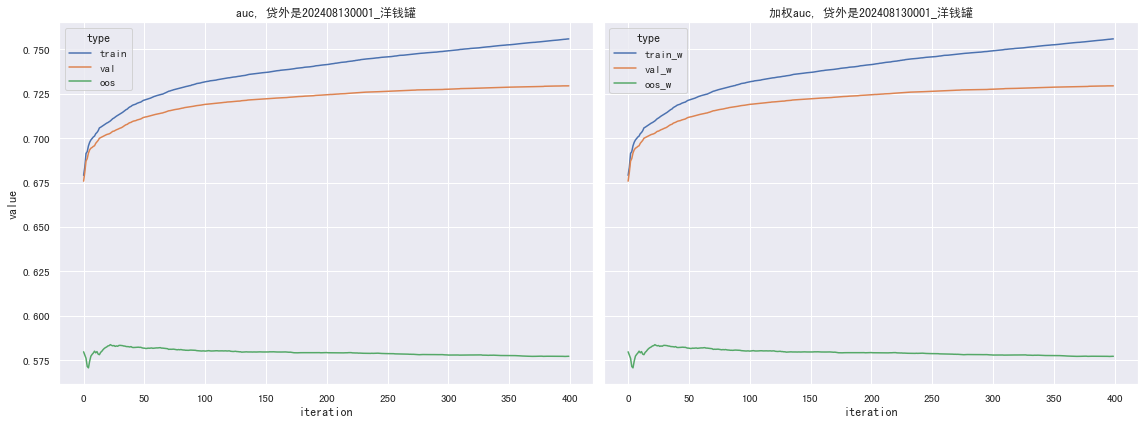

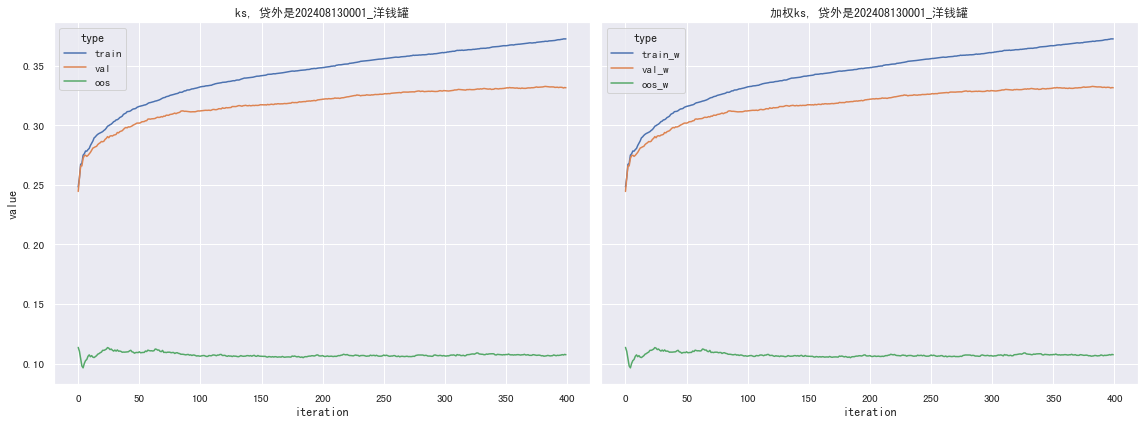

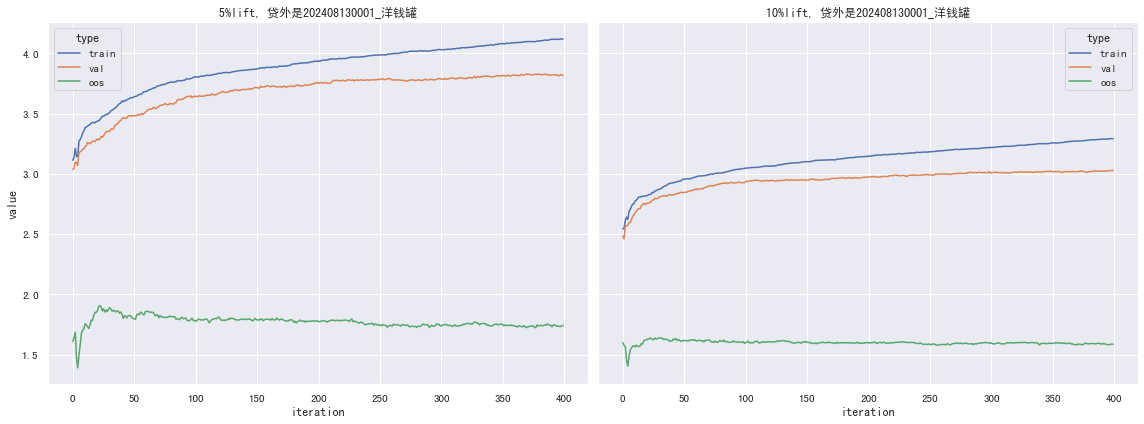

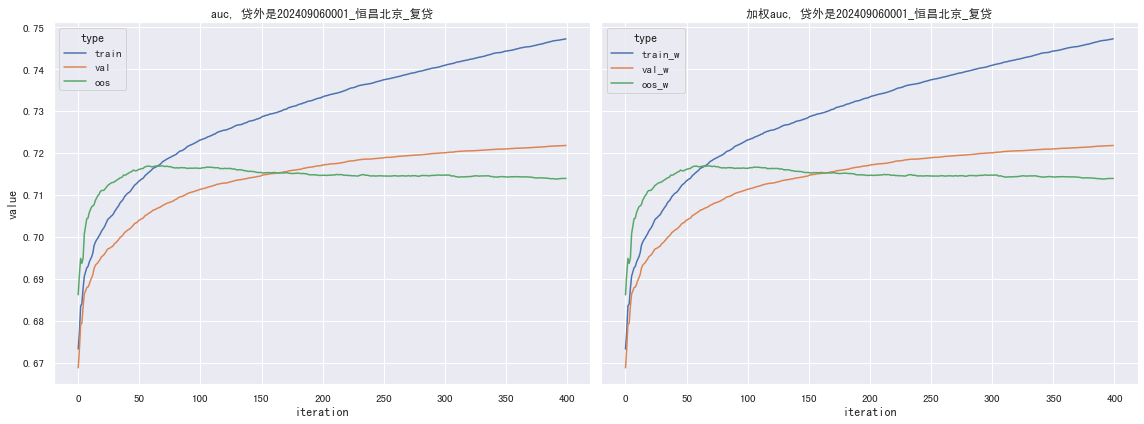

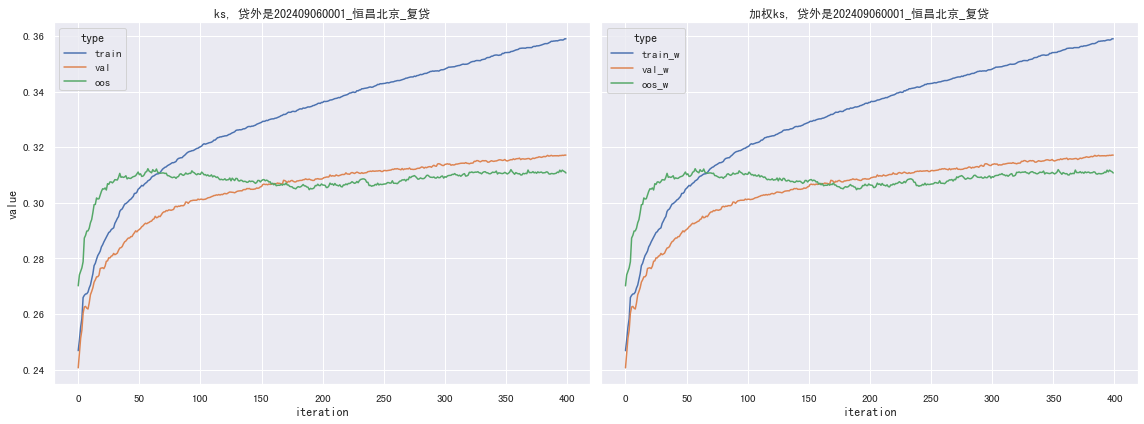

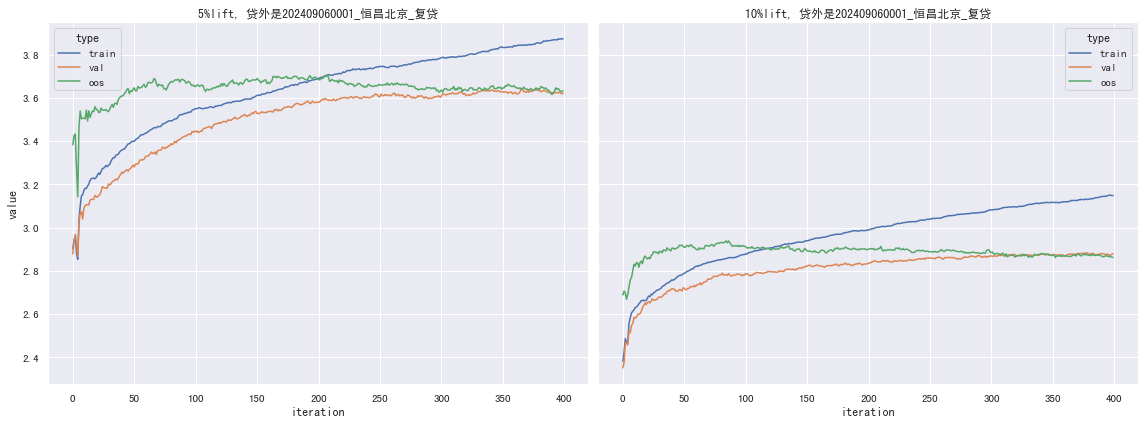

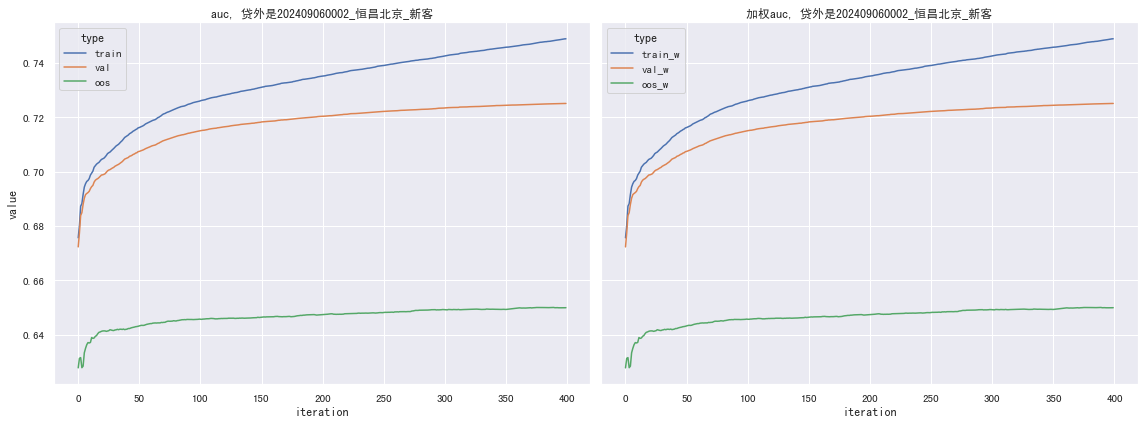

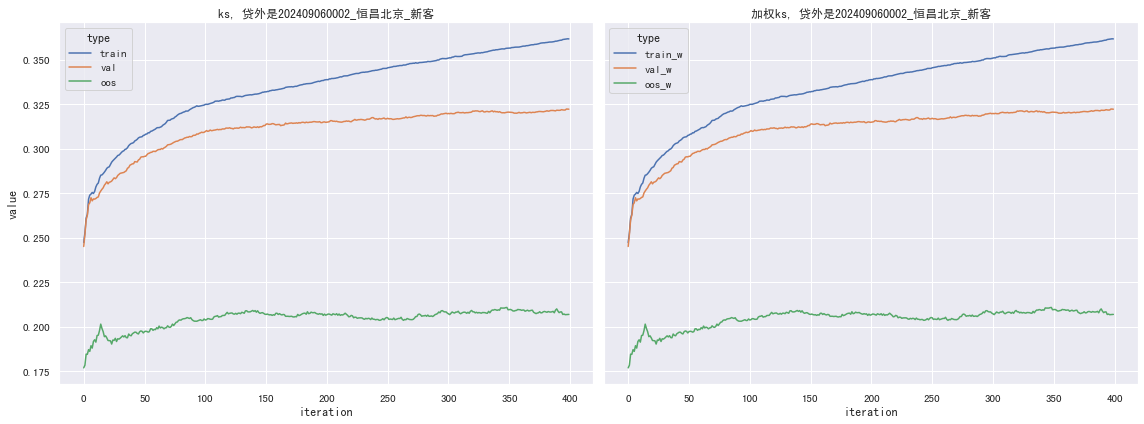

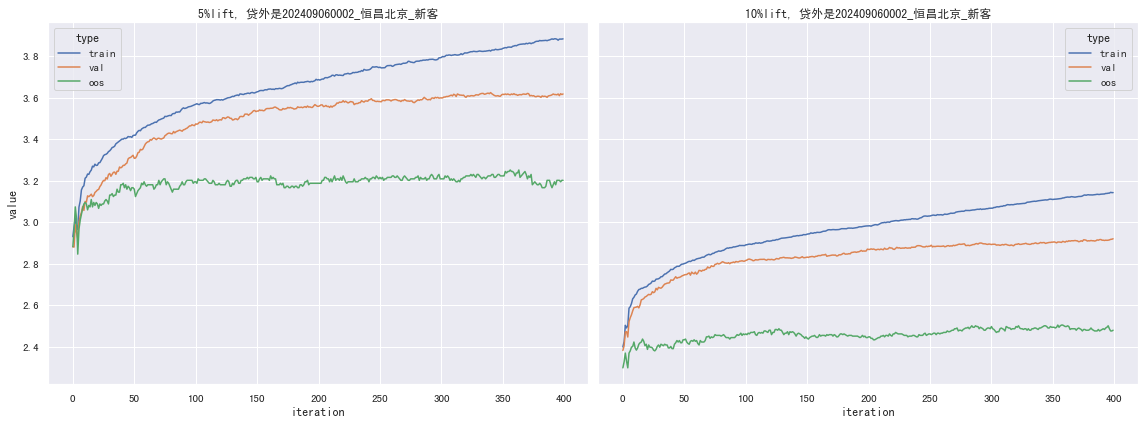

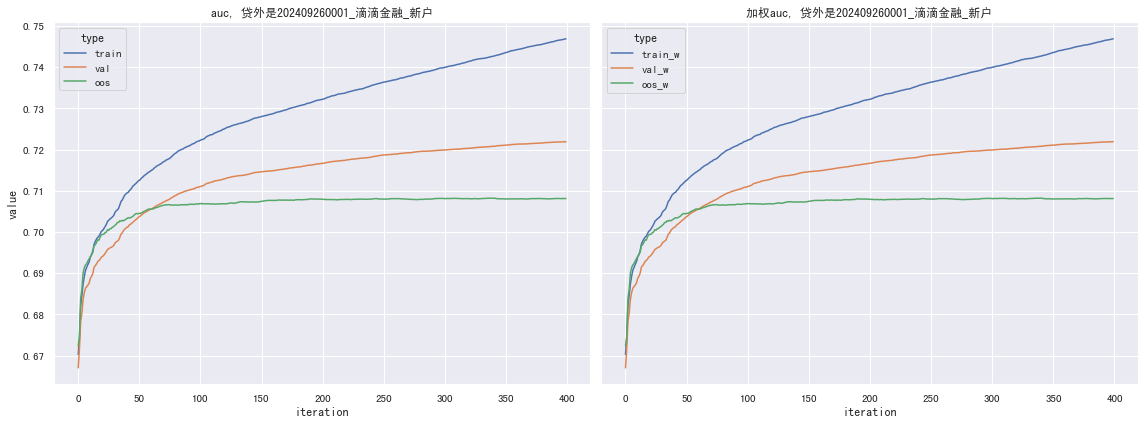

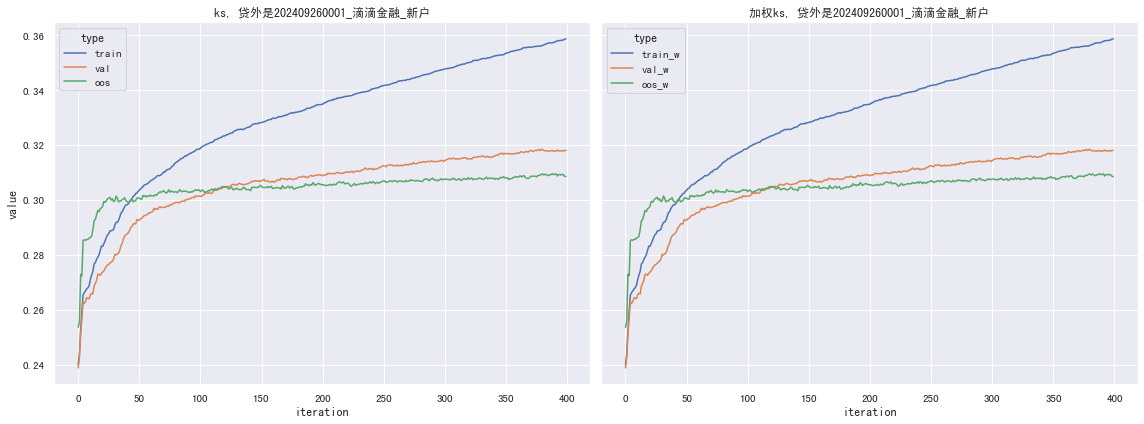

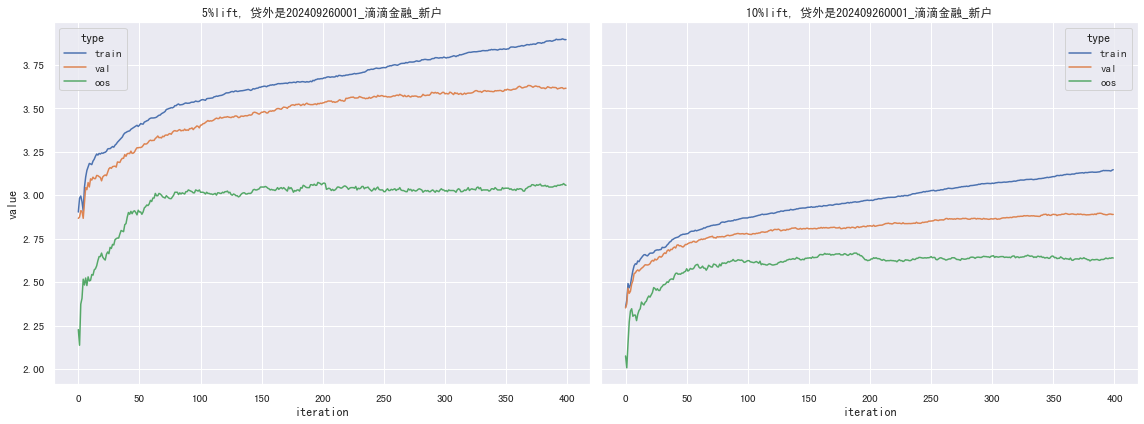

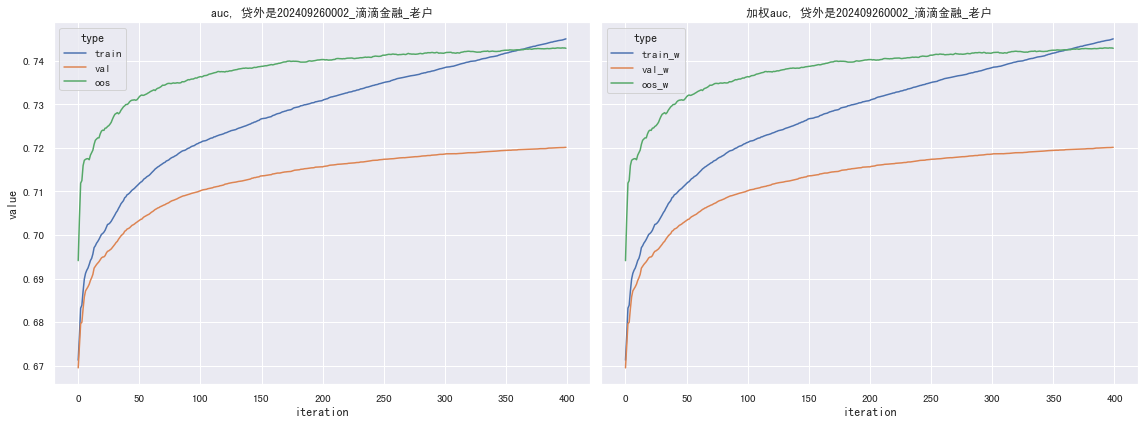

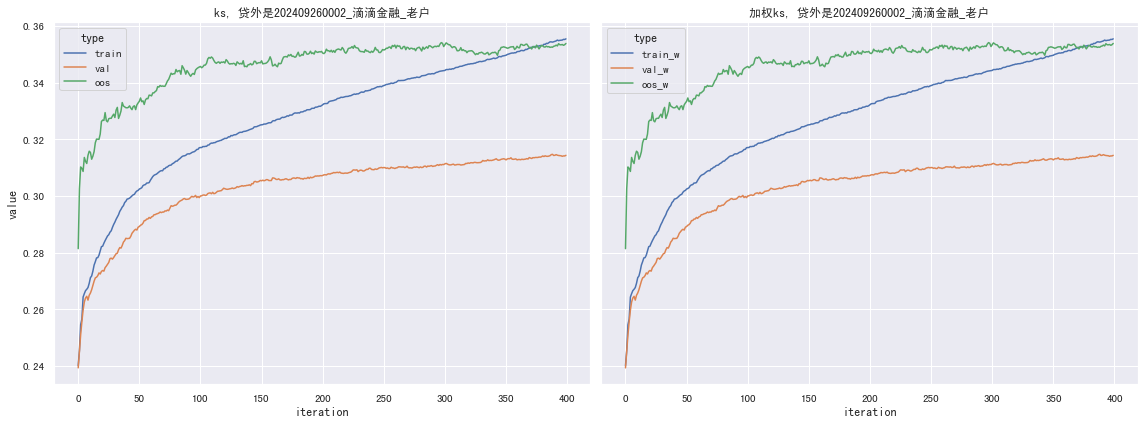

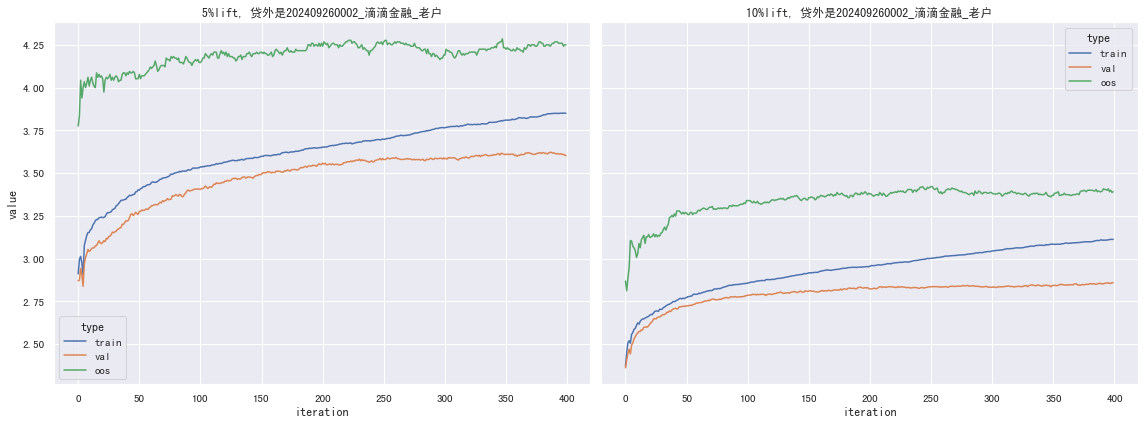

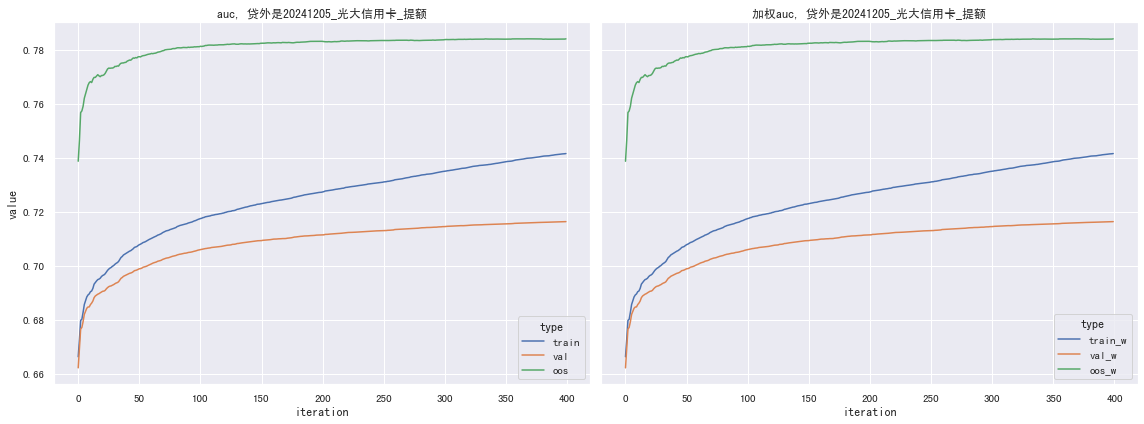

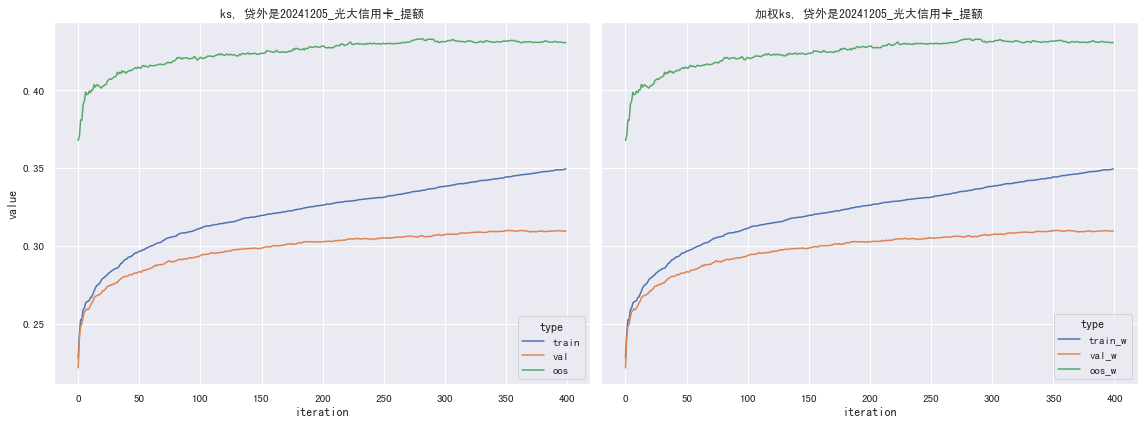

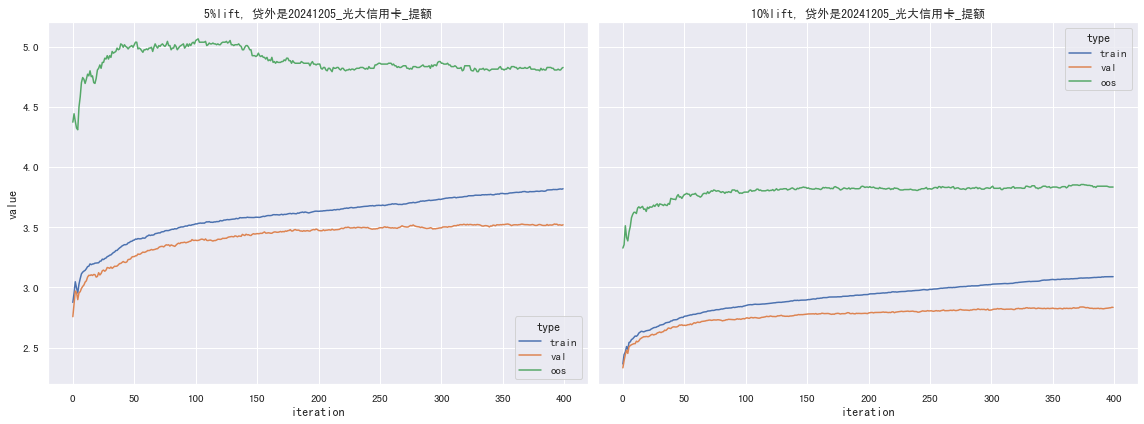

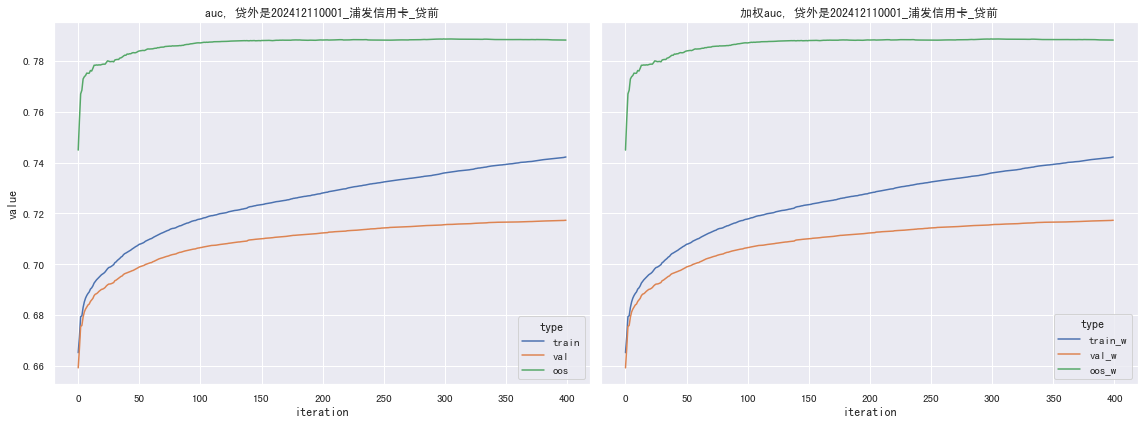

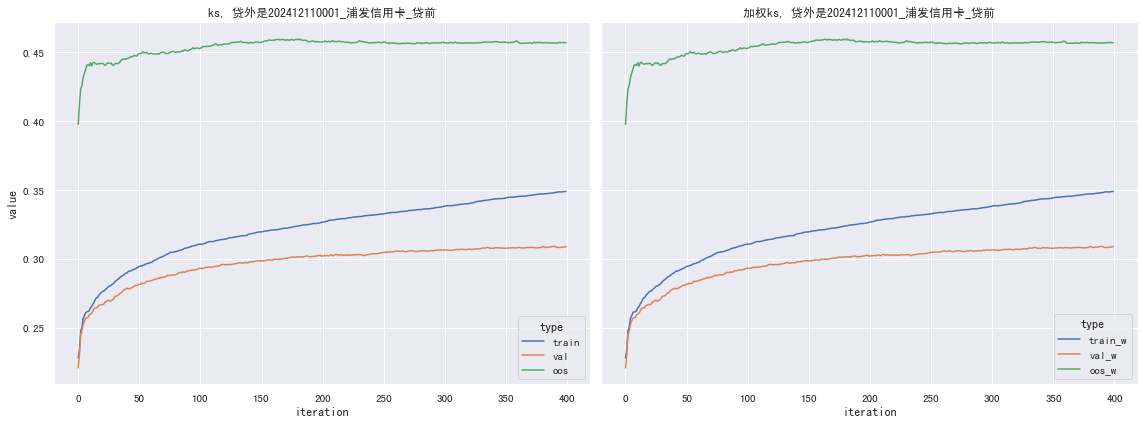

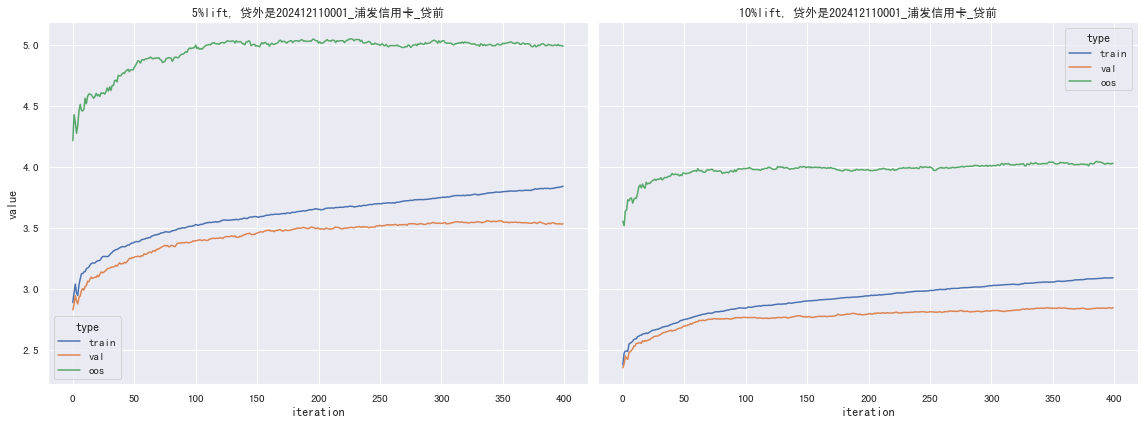

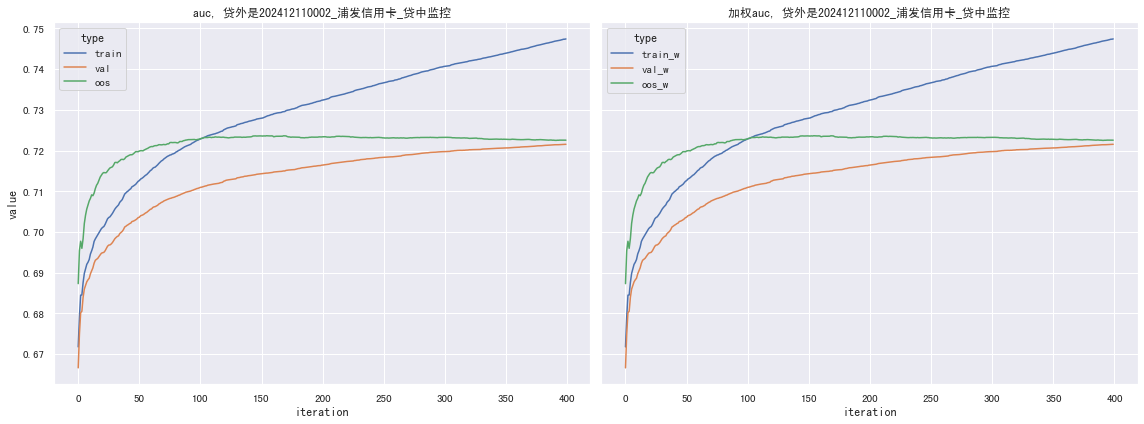

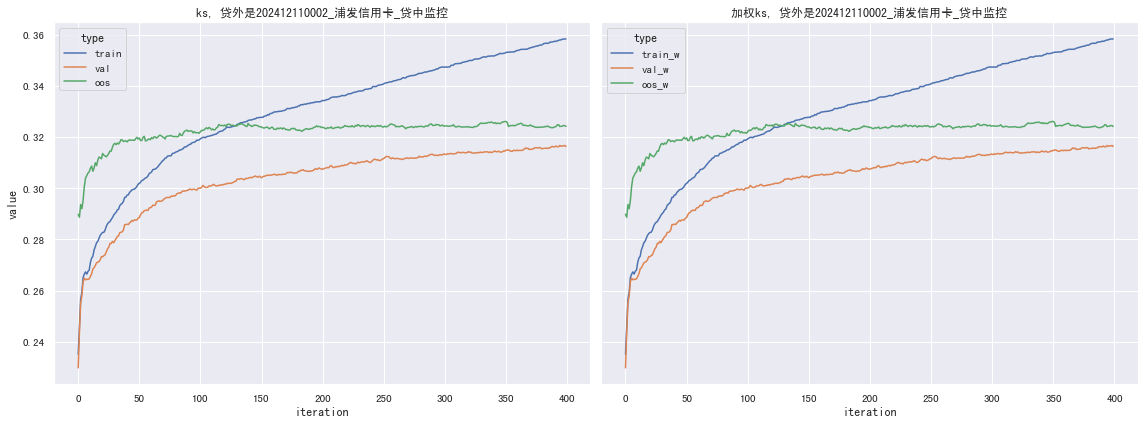

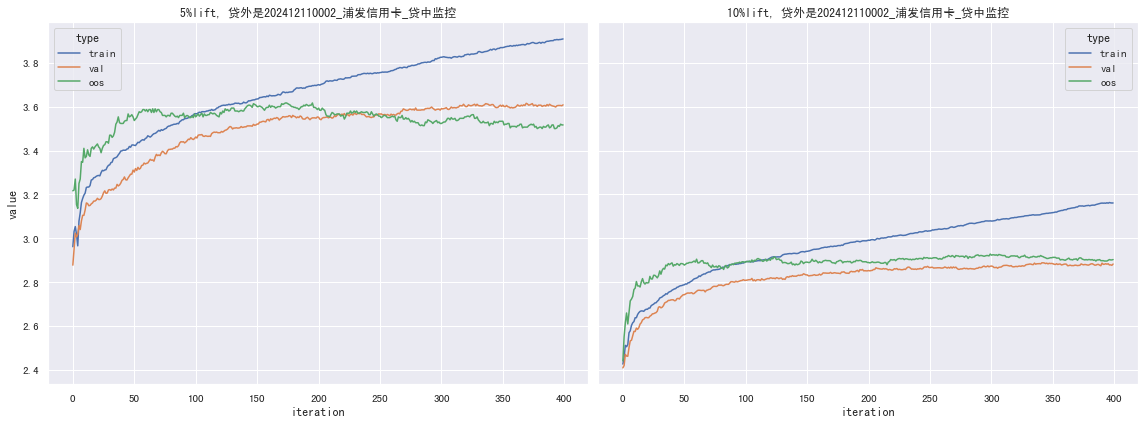

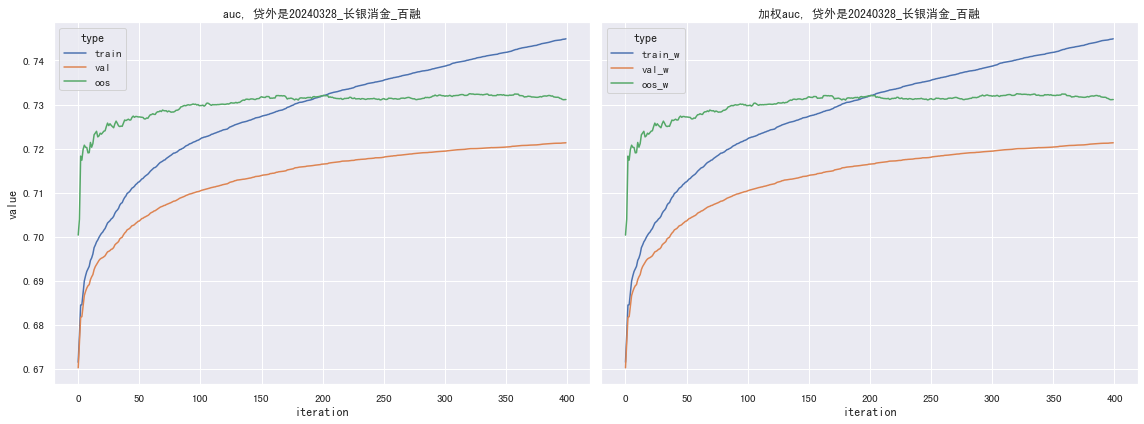

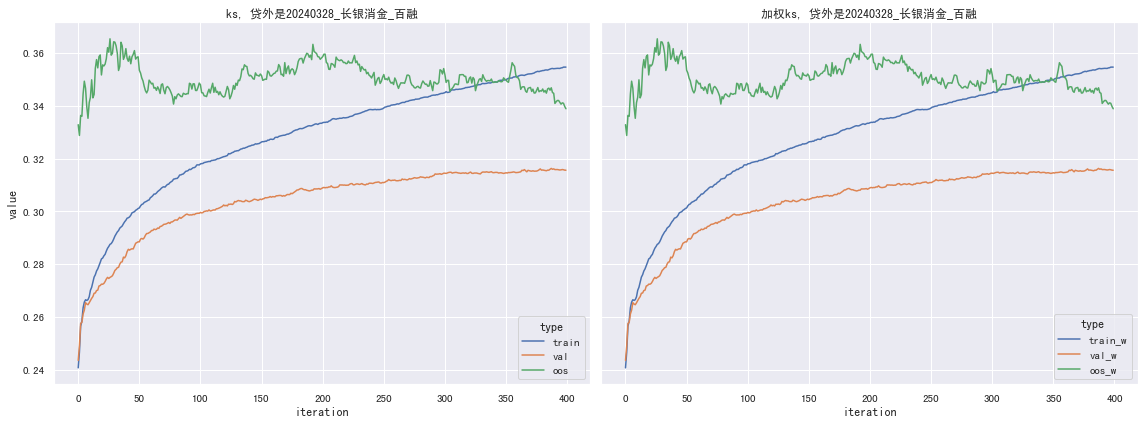

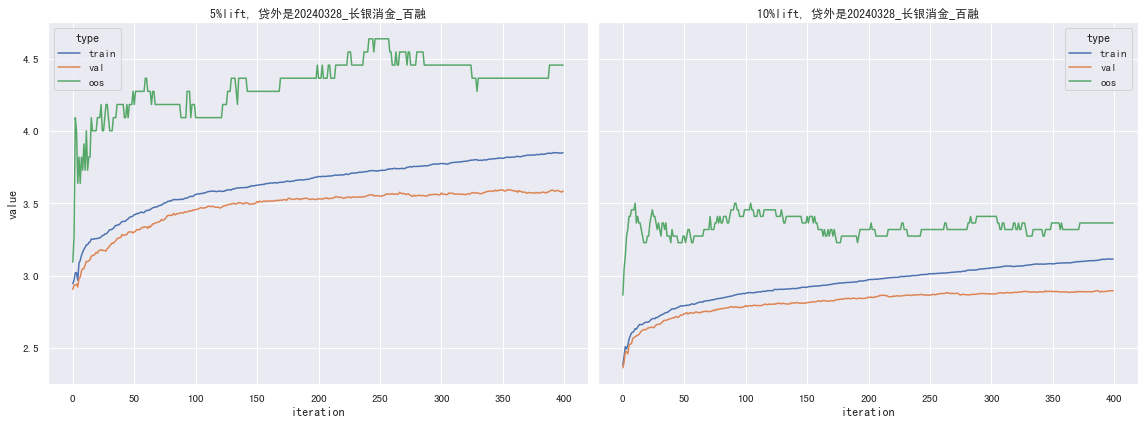

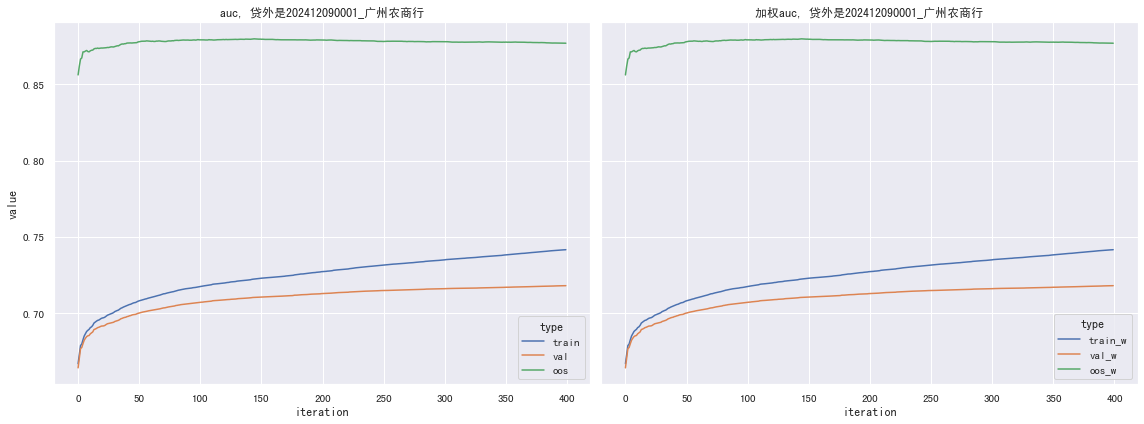

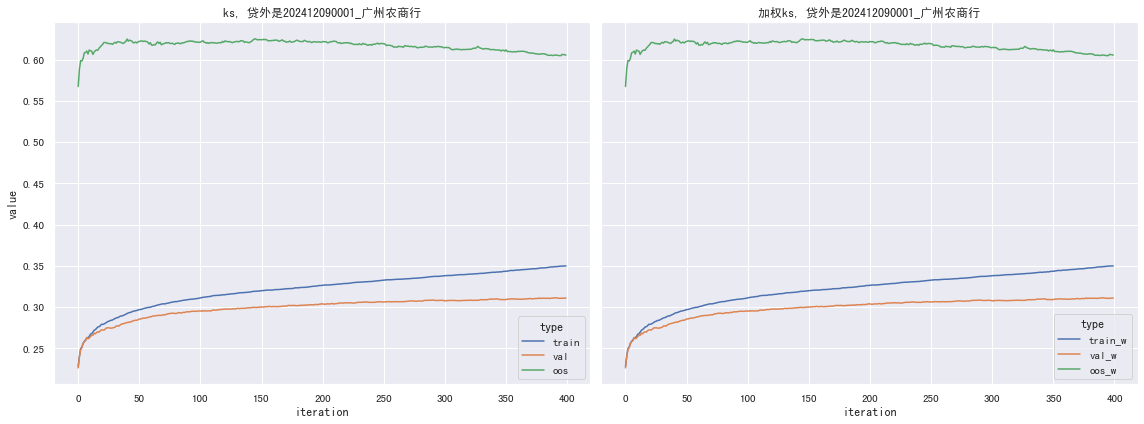

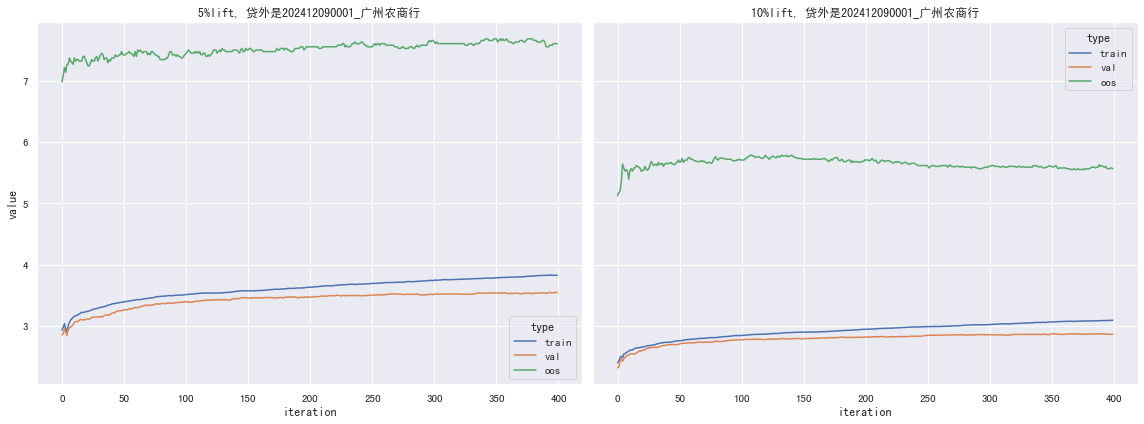

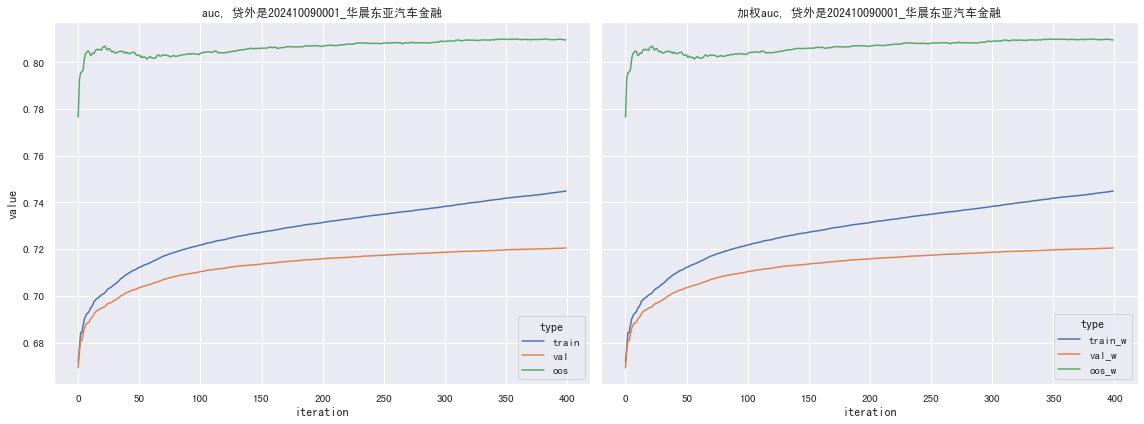

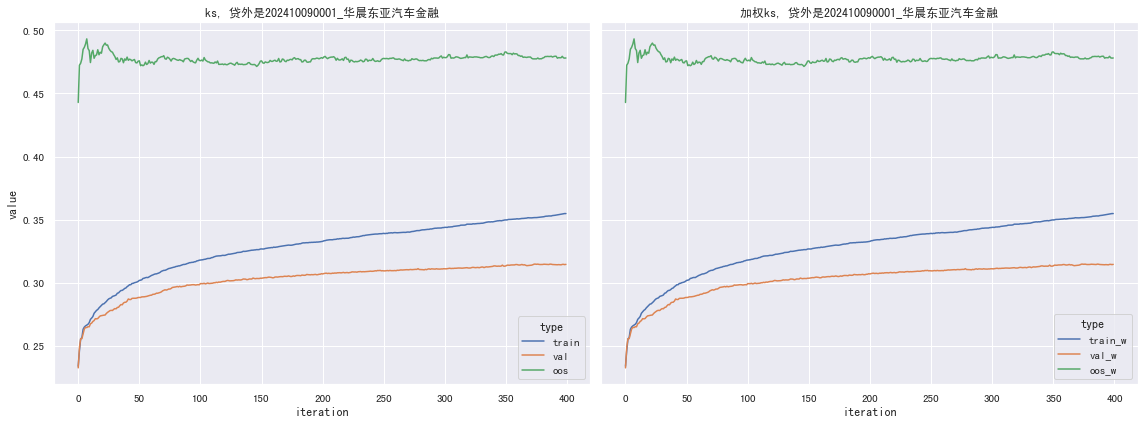

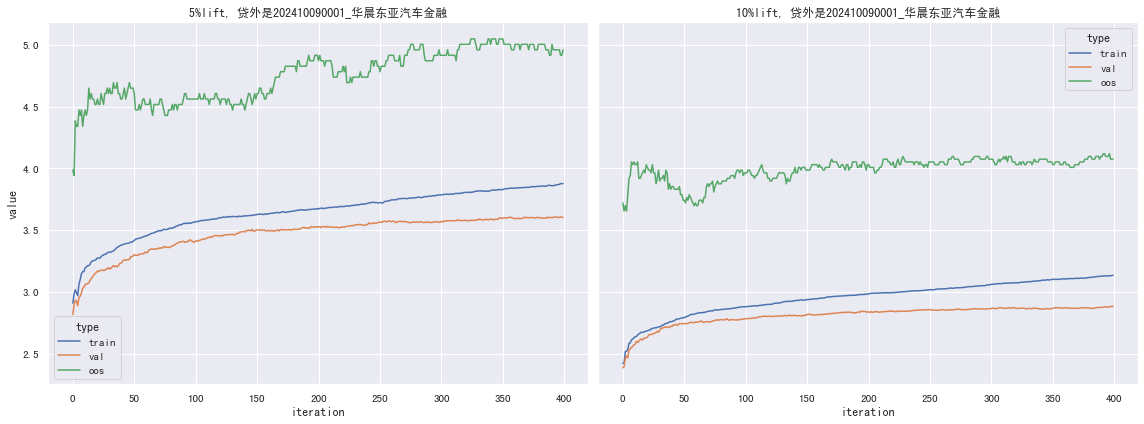

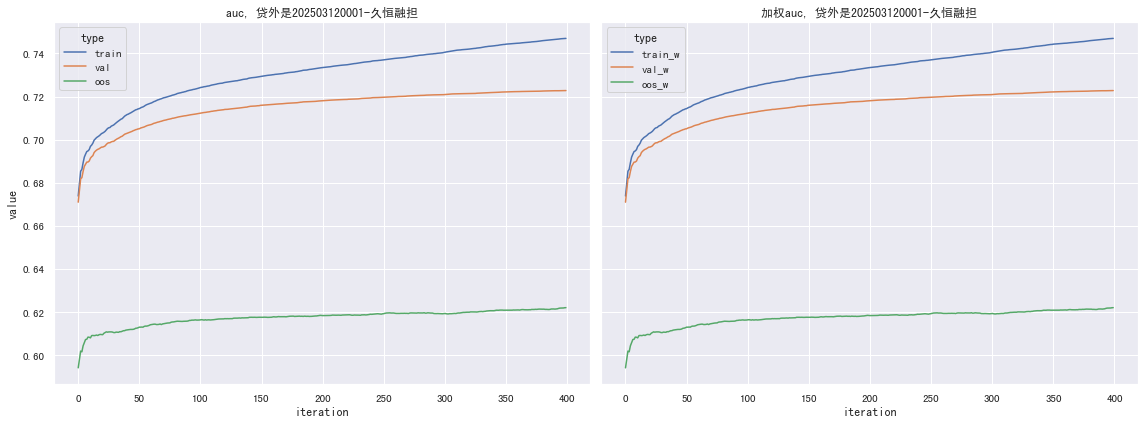

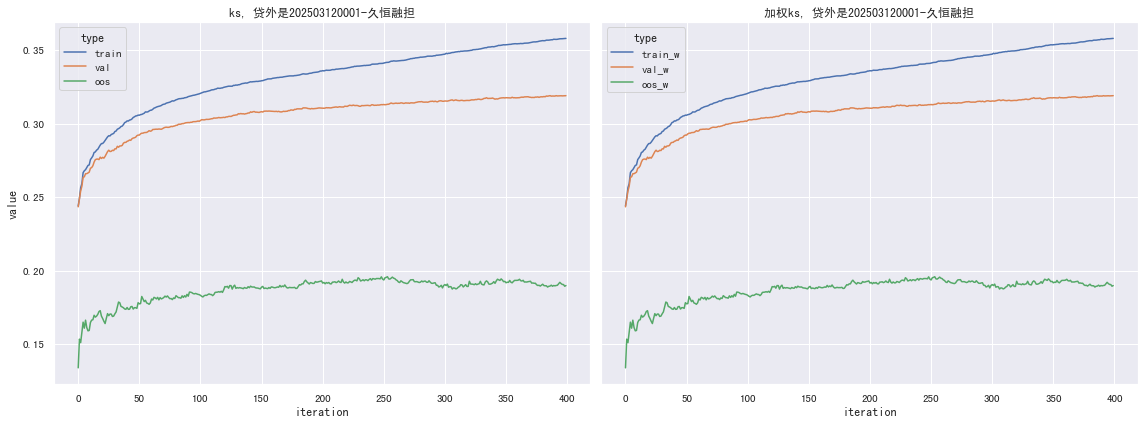

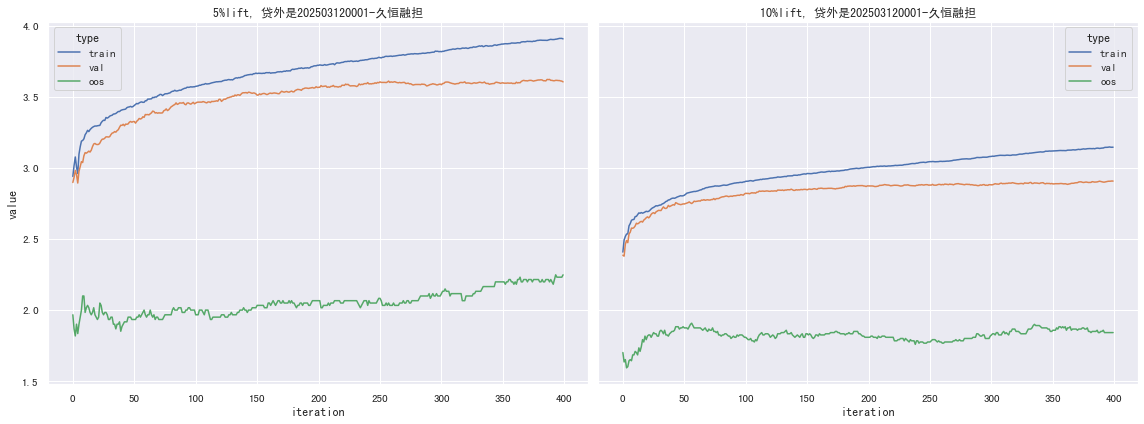

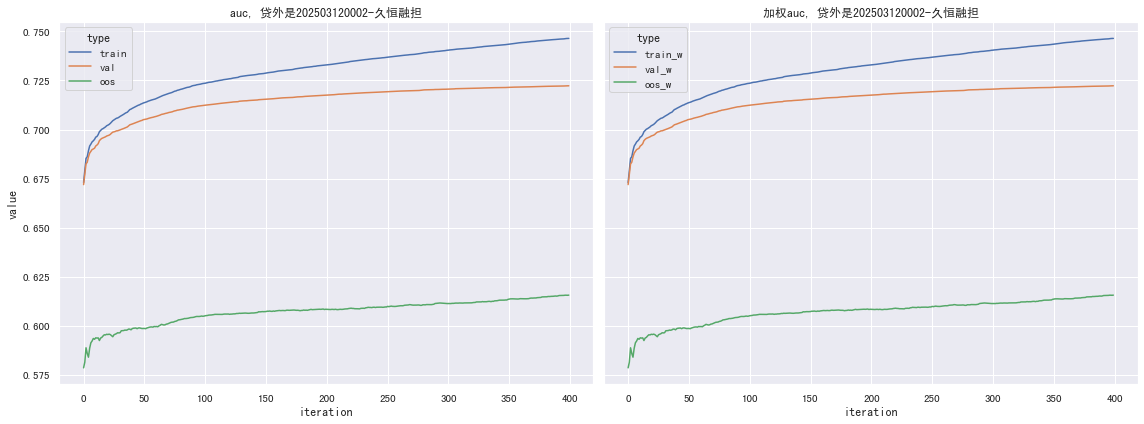

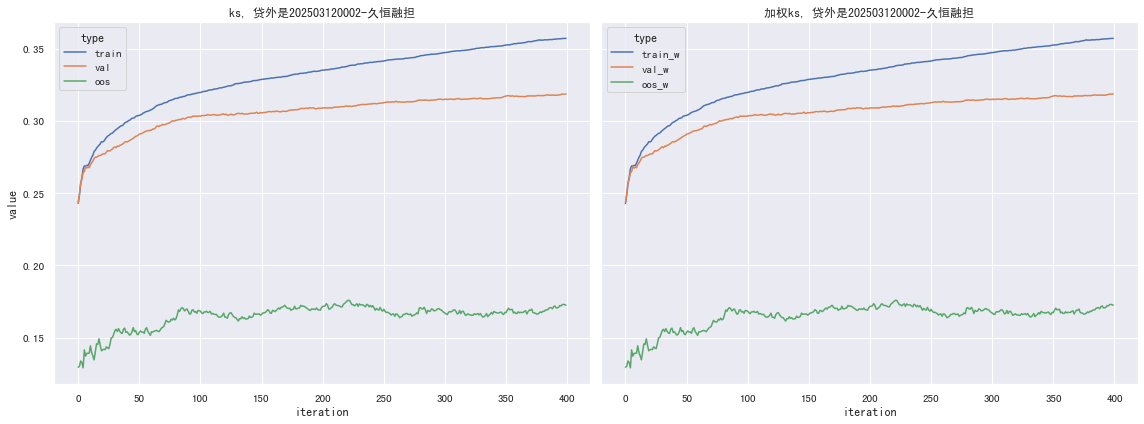

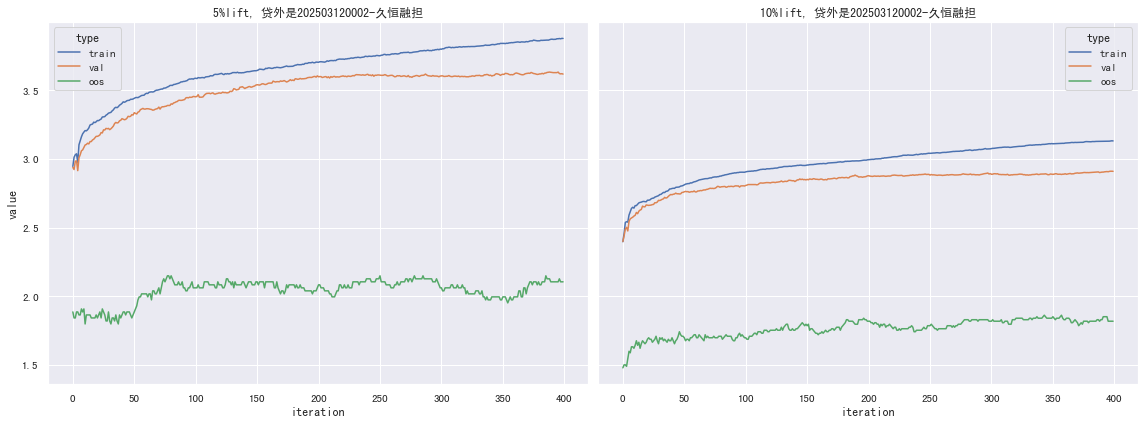

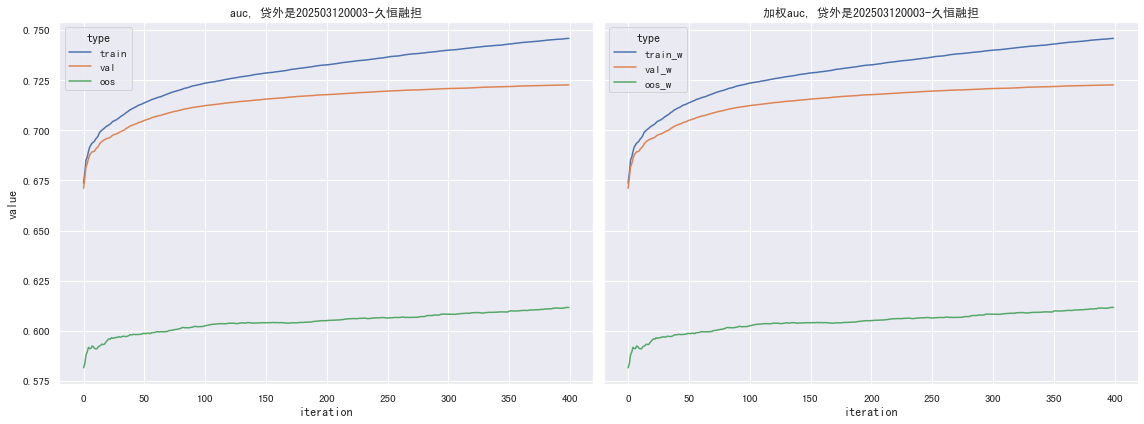

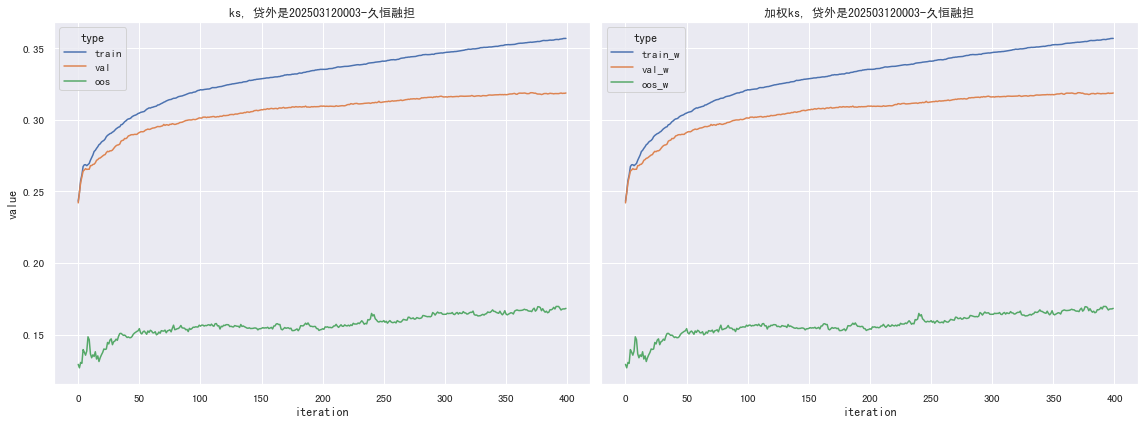

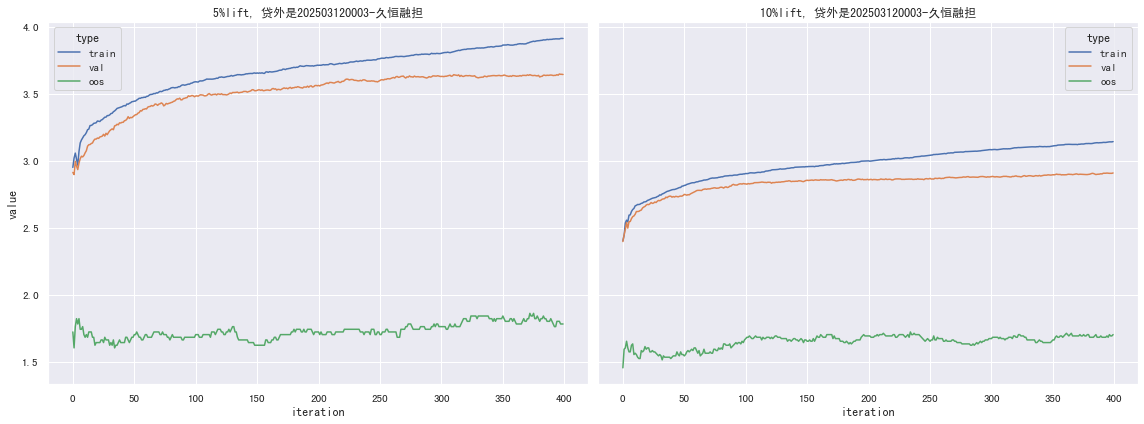

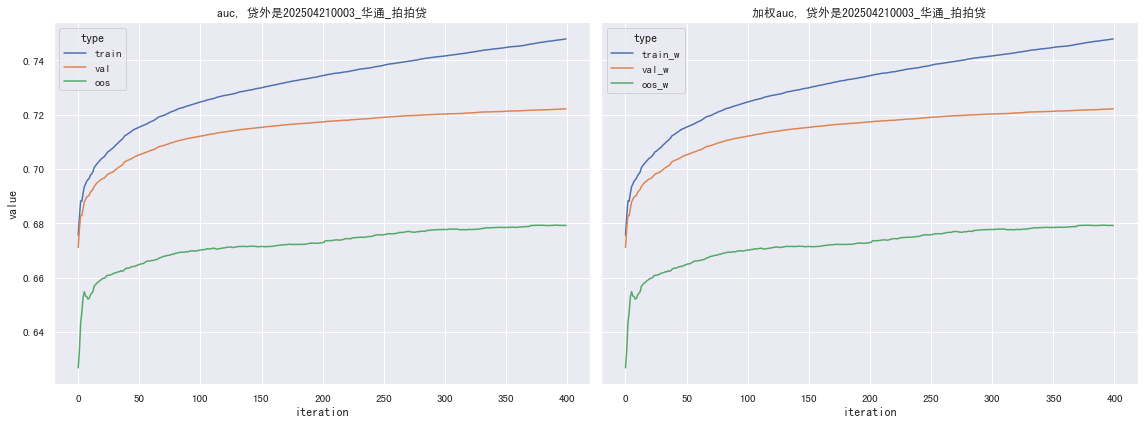

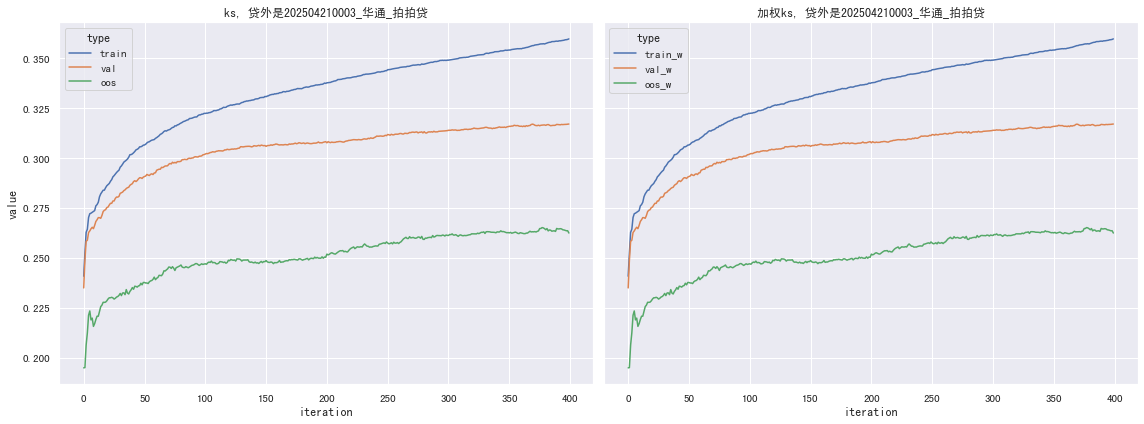

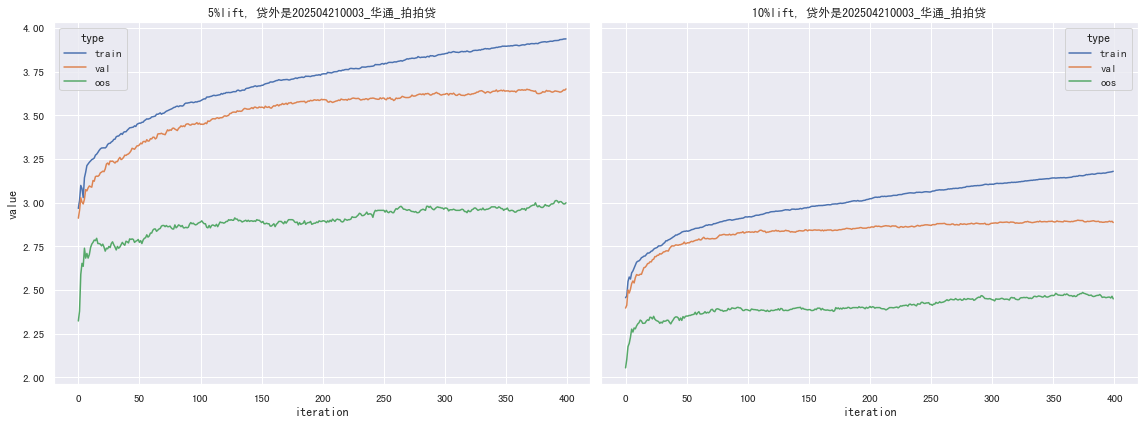

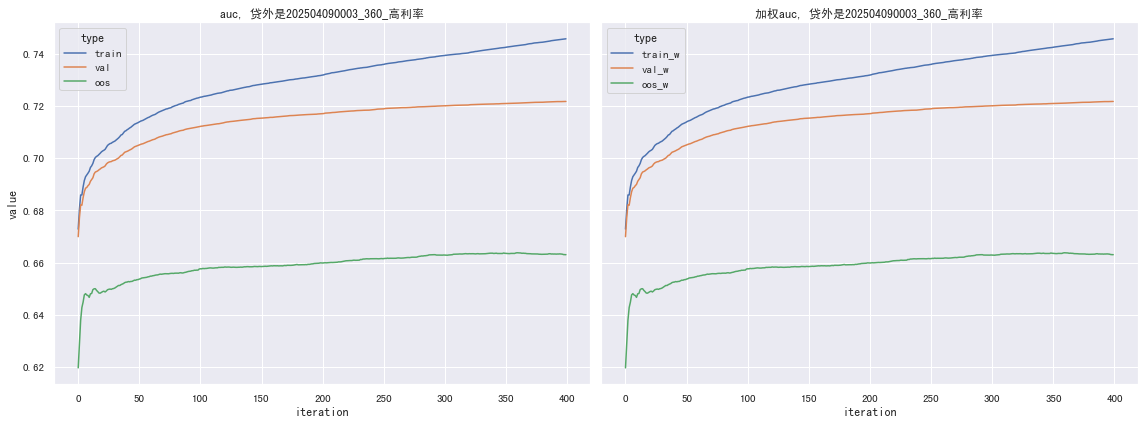

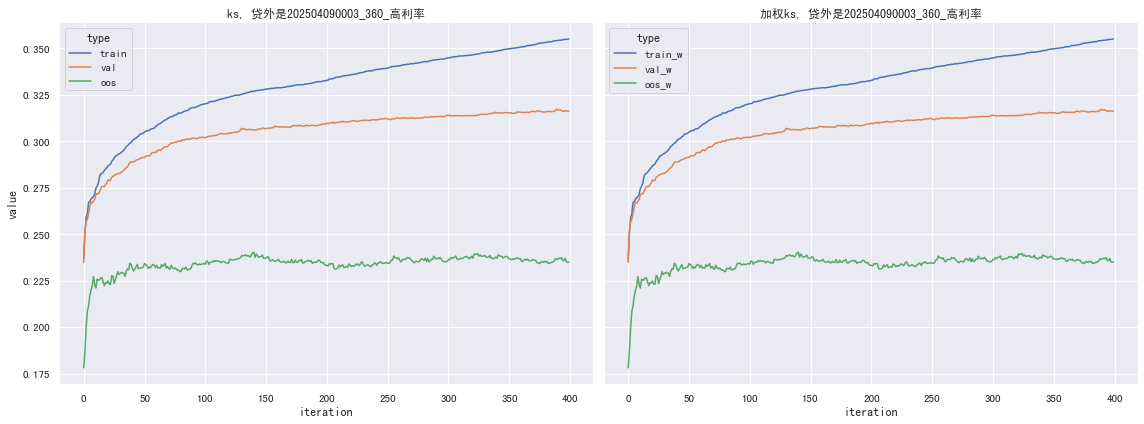

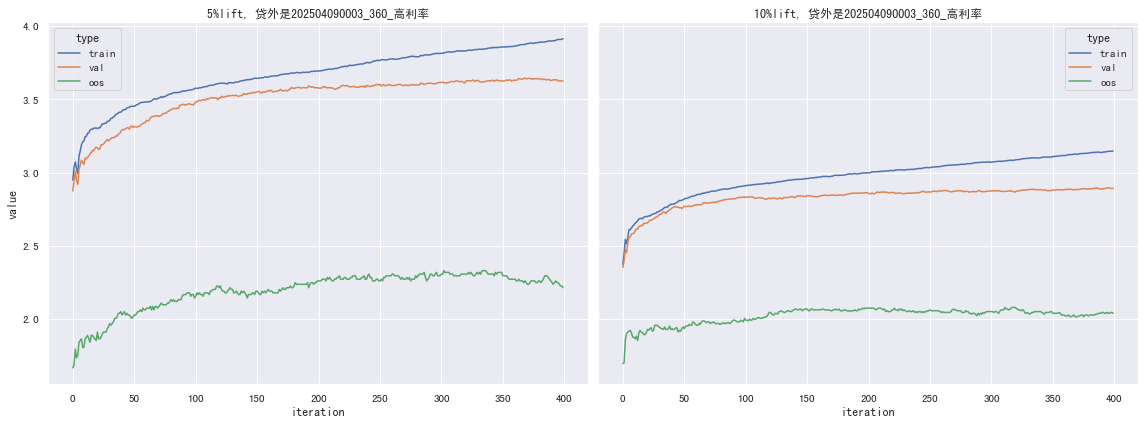

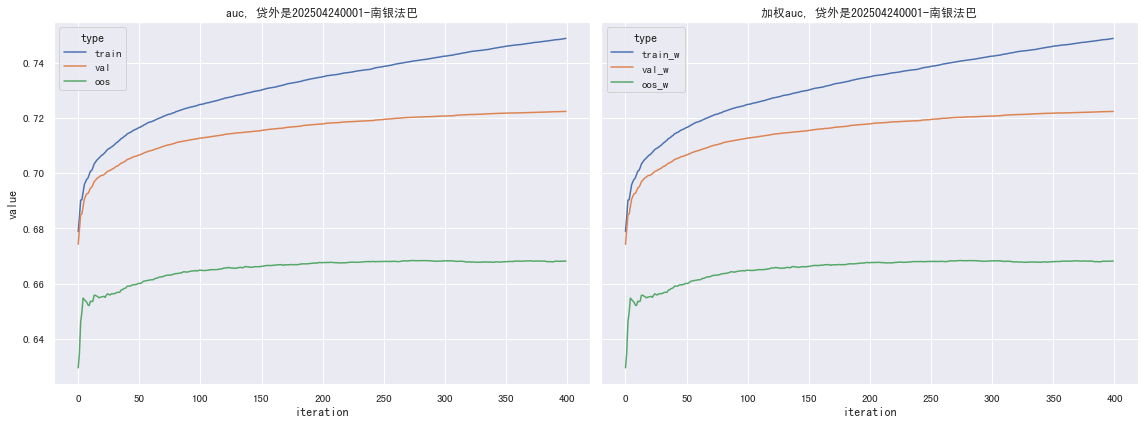

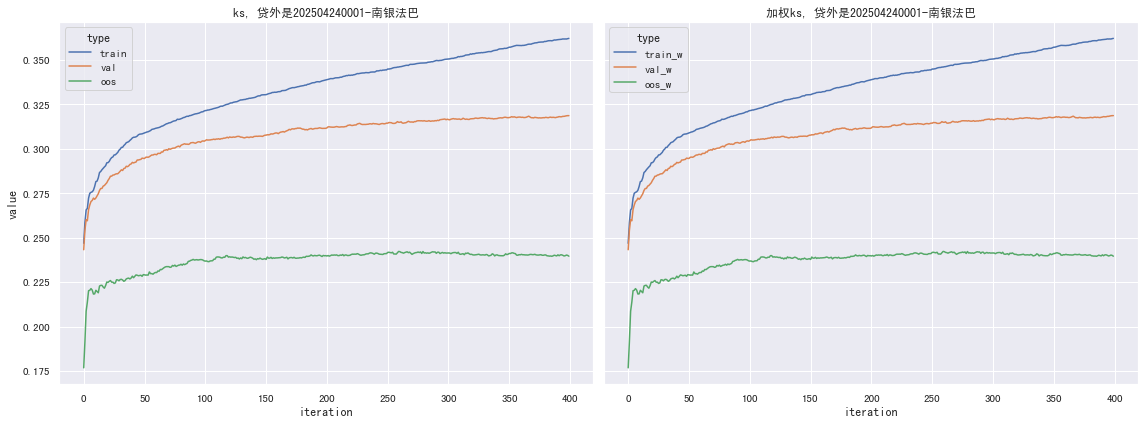

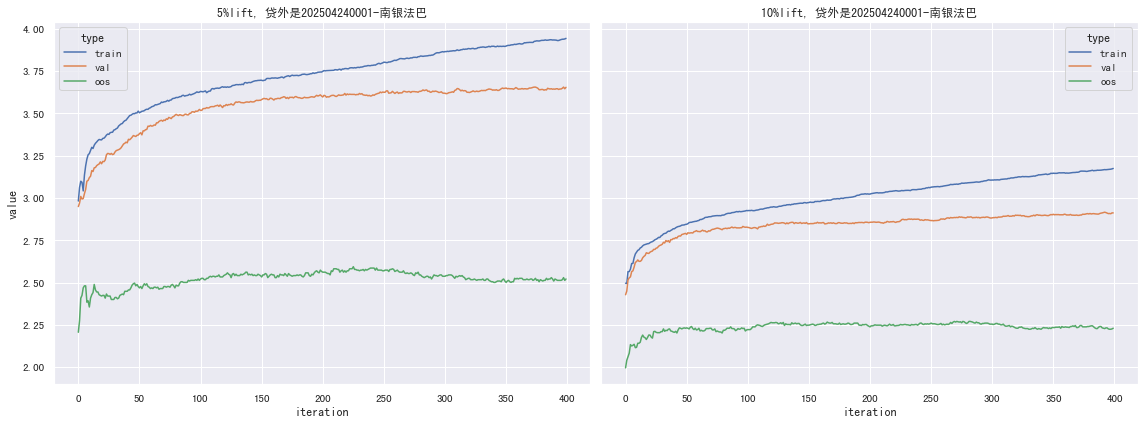

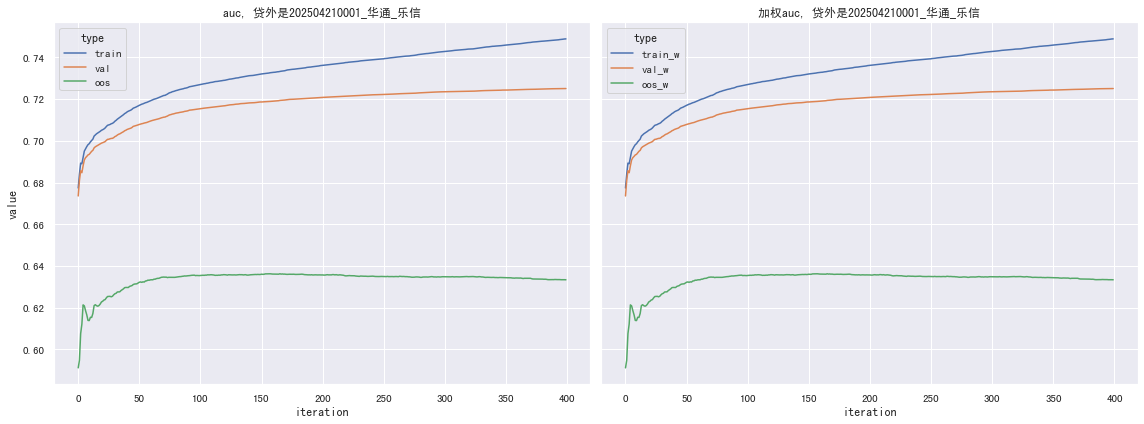

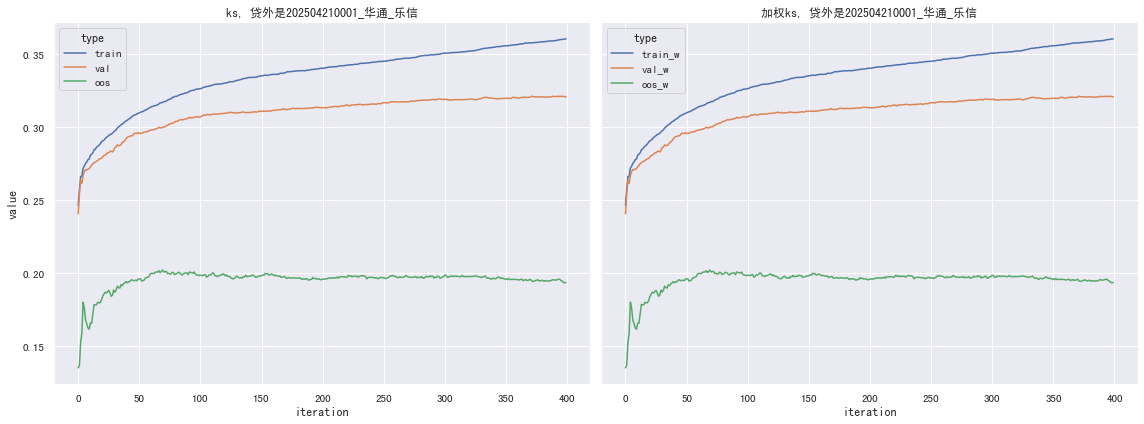

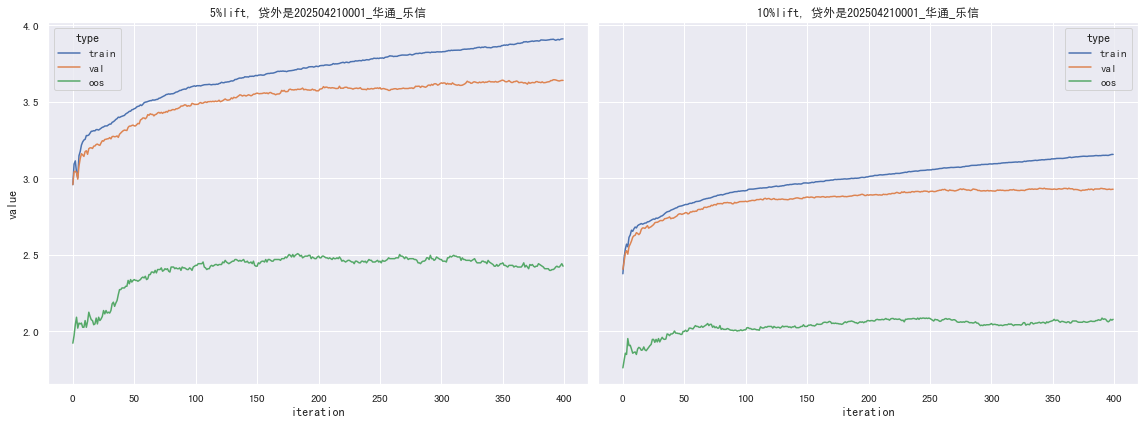

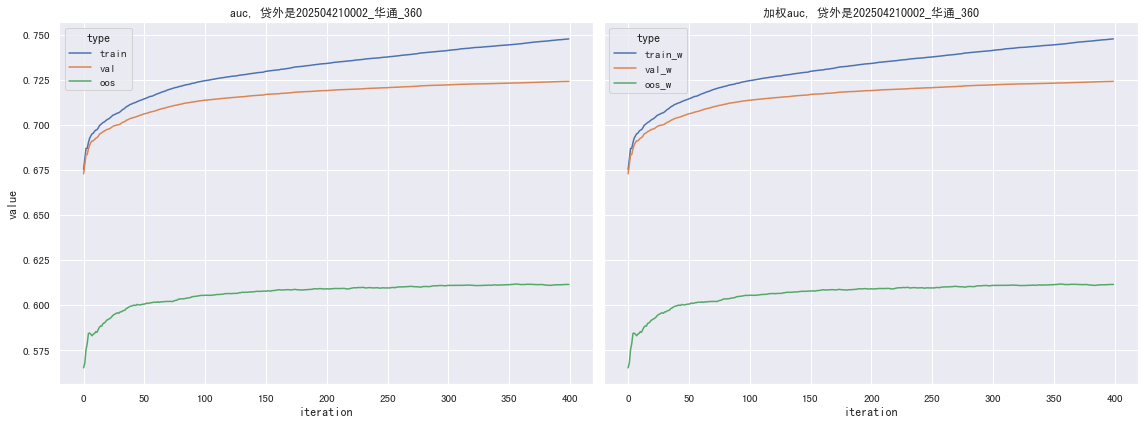

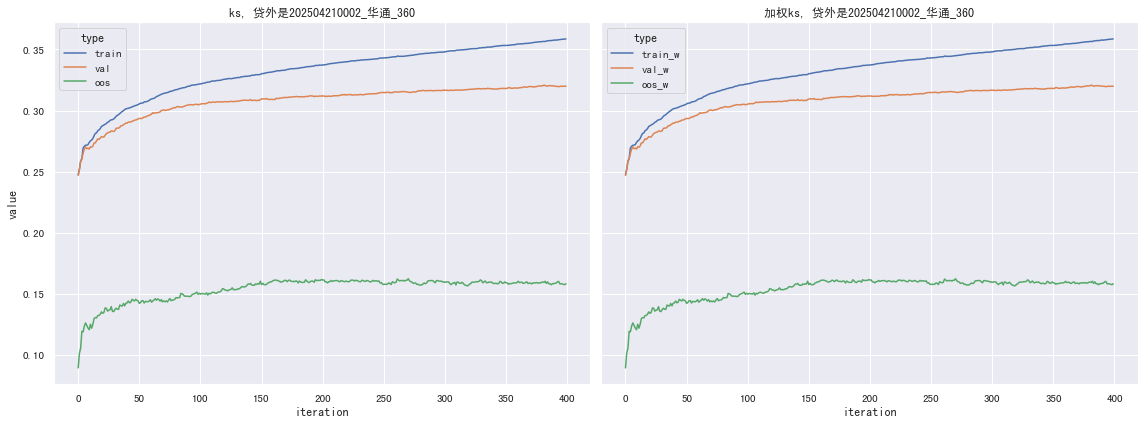

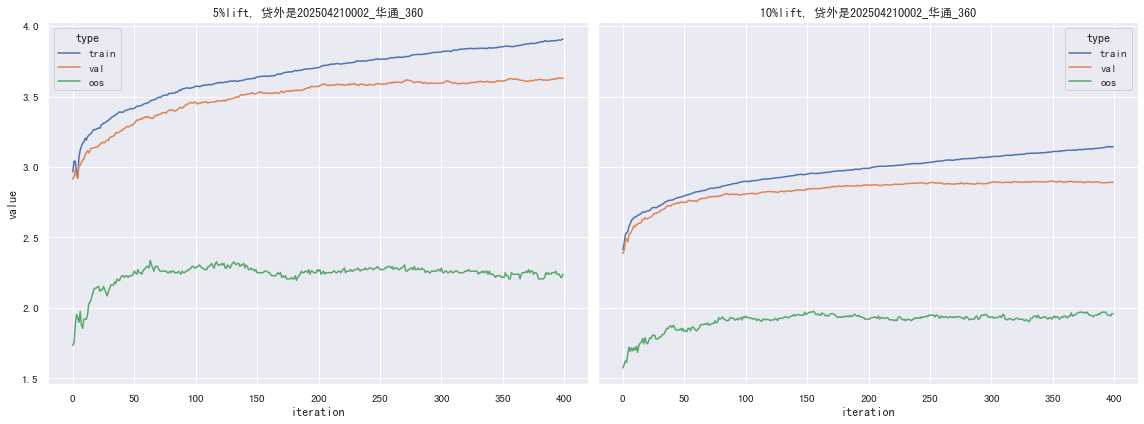

In [6]:
auto_ml.inference_model()